In [1]:
import os
import astroNN
from astroNN import datasets
from astroNN.apogee import allstar, visit_spectra, combined_spectra, gap_delete, apogee_continuum, bitmask_boolean
from astroNN.models import load_folder
from astroNN.apogee.chips import wavelength_solution, chips_split

from astropy.io import fits
from astropy.wcs import WCS
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import traceback

%matplotlib inline
import matplotlib.ticker as ticker

2023-06-11 12:39:09.796552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 12:39:17.195588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
geir_path = "/geir_data/scr/petershi" #should save work here 
sdssv_path = "/yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star" #path for SDSSV spectra
sdssiv_path = "/yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m"

xmatch_path = "/yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/aux_xmatch/ipl-1_dr17_lite_230517_byYS.fits"

model_path = "/home/petershi/MyFiles/astroNN_spectra_paper_figures/astroNN_0617_run001"

In [3]:
def getPathList(path_0):

    l = []

    for root, dirs, files in tqdm(os.walk(path_0, topdown=False)):
        for name in files:
            l.append(os.path.join(root, name))
        # for name in dirs:
        #     l.append(os.path.join(root, name))
    return (l, path_0)

In [4]:
sdssv_files = getPathList(sdssv_path)
sdssiv_files = getPathList(sdssiv_path)

10101it [04:38, 36.23it/s]
1585it [02:09, 12.19it/s]


In [5]:
len(sdssv_files[0])

1075373

In [6]:
len(sdssiv_files[0])

521606

In [7]:
example = sdssv_files[0][0]

hdul = fits.open(example)
hdul.info()

Filename: /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star/00/00/mwmStar-0.3.0-27021598754250000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   ()      
  1  BOSS/APO      1 BinTableHDU     19   0R x 0C   []   
  2  BOSS/LCO      1 BinTableHDU     19   0R x 0C   []   
  3  APOGEE/APO    1 BinTableHDU     83   1R x 11C   [1E, 8575E, 8575E, 8575E, 8575J, 8575E, 8575E, 21E, 50E, 1E, 1L]   
  4  APOGEE/LCO    1 BinTableHDU     19   0R x 0C   []   


In [8]:
print(repr(hdul[3].header))

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               206093 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
                                                                                
        METADATA                                                                
EXTNAME = 'APOGEE/APO'         / Short extension name                           
OBSRVTRY= 'APO     '           / Observatory name                               
INSTRMNT= 'APOGEE  '        

In [9]:
data = hdul[3].data
wave = data['LAMBDA']
flux = data['FLUX']
e_flux = data['E_FLUX']
bitmask = data['BITMASK']


In [10]:
data

FITS_rec([([243.32056], [15100.802 , 15101.01  , 15101.219 , 15101.428 , 15101.636 , 15101.845 , 15102.054 , 15102.262 , 15102.471 , 15102.68  , 15102.888 , 15103.097 , 15103.306 , 15103.514 , 15103.723 , 15103.932 , 15104.14  , 15104.349 , 15104.558 , 15104.766 , 15104.975 , 15105.184 , 15105.392 , 15105.601 , 15105.81  , 15106.019 , 15106.227 , 15106.436 , 15106.645 , 15106.853 , 15107.062 , 15107.2705, 15107.4795, 15107.6875, 15107.896 , 15108.105 , 15108.313 , 15108.522 , 15108.731 , 15108.94  , 15109.148 , 15109.357 , 15109.566 , 15109.775 , 15109.983 , 15110.192 , 15110.401 , 15110.61  , 15110.819 , 15111.027 , 15111.236 , 15111.445 , 15111.654 , 15111.862 , 15112.071 , 15112.28  , 15112.489 , 15112.698 , 15112.906 , 15113.115 , 15113.324 , 15113.533 , 15113.742 , 15113.95  , 15114.159 , 15114.368 , 15114.577 , 15114.786 , 15114.995 , 15115.203 , 15115.412 , 15115.621 , 15115.83  , 15116.039 , 15116.248 , 15116.457 , 15116.665 , 15116.874 , 15117.083 , 15117.292 , 15117.501 , 151

In [11]:
cols = hdul[3].columns
cols.names

['SNR',
 'LAMBDA',
 'FLUX',
 'E_FLUX',
 'BITMASK',
 'MODEL_FLUX',
 'CONTINUUM',
 'CONTINUUM_THETA',
 'CONTINUUM_PHI',
 'CONTINUUM_RCHISQ',
 'CONTINUUM_SUCCESS']

In [12]:
print(repr(hdul[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
                                                                                
        METADATA                                                                
V_ASTRA = '0.3.0   '           / Astra version                                  
CREATED = '23-02-23 14:44:26'  / File creation time (UTC %y-%m-%d %H:%M:%S)     
HEALPIX =                92297 / Healpix location (128 sides)                   
                                                                                
        IDENTIFIERS                                                             
GAIA_ID =  4278066707085552000 / Gaia DR3 source identifier                     
TIC_ID  =            2691327

In [7]:
example2 = sdssiv_files[0][0]

hdul2 = fits.open(example2)
hdul2.info()

Filename: /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m/120+12/apStar-dr17-2M00000002+7417074.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     121   ()      
  1                1 ImageHDU        12   (8575, 5)   float64   
  2                1 ImageHDU        12   (8575, 5)   float64   
  3                1 ImageHDU        12   (8575, 5)   int64   
  4                1 ImageHDU        12   (8575, 5)   float64   
  5                1 ImageHDU        12   (8575, 5)   float64   
  6                1 ImageHDU        12   (8575, 5)   float64   
  7                1 ImageHDU        12   (8575, 5)   float64   
  8                1 ImageHDU         5   ()      
  9                1 BinTableHDU     58   3R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 765D, 765D, 765D, D, D, D, D, D, 765D]   
 10                1 BinTableHDU     58   1R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 243D, 243D, 243D, D, D, 

In [39]:
print(repr(hdul2[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CRVAL1  =                4.179 / Start log10(wavelength) in subsequent HDUs     
CDELT1  =                6E-06 / Dispersion in log10(wave) in subsequent HDUs   
CRPIX1  =                    1 / Pixel of starting wavelength in subsequent HDUs
CTYPE1  = 'LOG-LINEAR'         / Logarithmic wavelength scale in subsequent HDUs
DC-FLAG =                    1 / Logarithmic wavelength scale in subsequent HDUs
NWAVE   =                 8575 / Number of wavelengths in subsequent HDUs       
FIELD   = '120+12  '           / APOGEE field name                              
OBJID   = '2M00000002+7417074' / APOGEE object name                             
SNR     =    827.15650881456

In [32]:
print(hdul2[9].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                24696 / length of dimension 1                          NAXIS2  =                    3 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   23 / number of table fields                         TTYPE1  = 'filename'                                                            TFORM1  = '72A     '                                                            TTYPE2  = 'jd      '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'snr     '                    

In [15]:
print(hdul2[0].header["RA"])

0.000103


In [16]:
hdul2[1].data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [17]:
target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
_spec = gap_delete(flux, dr=17)
_spec_err = gap_delete(e_flux, dr=17)
_spec_mask = gap_delete(bitmask, dr=17)
_normspec, _spec_err = apogee_continuum(_spec, _spec_err, bitmask=_spec_mask, target_bit=target_bit, dr=17, mask_value=1.)

In [18]:
_normspec


array([[0.58083576, 0.69168335, 0.85182965, ..., 0.9798036 , 0.96896863,
        0.94296163]], dtype=float32)

In [19]:
lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=17)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

In [20]:
blue, green, red = chips_split(_normspec[0], dr=17)
blue, green, red = blue[0], green[0], red[0] # from visit spectra 

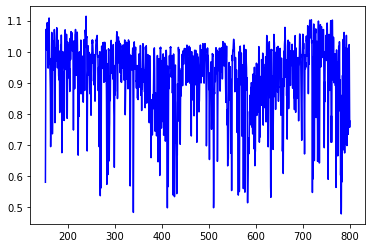

In [21]:
plt.plot(lambda_blue, blue, linewidth=1.5,rasterized=True, label='Continuum Normalization', color = 'b')

In [22]:
xmatch = fits.open(xmatch_path)
xmatch.info()

Filename: /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/aux_xmatch/ipl-1_dr17_lite_230517_byYS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (17173,)   uint8   
  1  Joined        1 BinTableHDU    723   27571R x 352C   [K, K, K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, 30A, 84A, 30A, K, K, K, 5A, 7A, 6A, 5A, 3A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 30A, 6A, 20A, 30A, D, D, D, D, E, E, E, E, E, E, E, 32A, E, E, J, J, J, J, J, J, 132A, 32A, 32A, J, E, E, K, 132A, K, 132A, E, E, E, E, E, E, E, E, E, E, E, J, J, E, E, E, E, E, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, 

In [23]:
cat = xmatch[1].data["cat_id"]

In [24]:
apo = xmatch[1].data["APOGEE_ID"]

In [25]:
print(len(cat), len(apo))

27571 27571


In [26]:
print(cat[0], apo[0])

329915927 2M02222833-0609582


# Functions

In [27]:
def getPath(s, l):
    for elem in l[0]:
        if str(s) in elem:
            return elem

    print("File " + str(s) + " not found in " + str(l[1]))
    return None

In [28]:
def getSDSSIVData(hdul, ind):
    
    snr = hdul[0].header["SNR"]
    ra = hdul[0].header["RA"]
    dec = hdul[0].header["DEC"]
    flux = hdul[1].data
    flux_err = hdul[2].data
    bitmask = hdul[3].data

    rd = {}

    rd["Index"] = ind
    rd["SNR"] = snr
    rd["RA"] = ra
    rd["DEC"] = dec
    rd["FLUX"] = flux
    rd["FLUX_ERR"] = flux_err
    rd["BITMASK"] = bitmask

    return rd 

In [29]:
def getSDSSVData(hdul, ind):

    snr = hdul[3].data["SNR"]
    ra = hdul[0].header["RA"]
    dec = hdul[0].header["DEC"]
    flux = hdul[3].data["FLUX"]
    flux_err = hdul[3].data["E_FLUX"]
    bitmask = hdul[3].data["BITMASK"]

    rd = {}

    rd["Index"] = ind
    rd["SNR"] = snr
    rd["RA"] = ra
    rd["DEC"] = dec
    rd["FLUX"] = flux
    rd["FLUX_ERR"] = flux_err
    rd["BITMASK"] = bitmask

    return rd 
    

In [30]:
def getSpectrumSDSSIV(hdul, raw = False):
      # read the raw spectra from apstar
      _spec = np.vstack((hdul[1].data, hdul[1].data)) # why the vstack tho...
      _spec_err = np.vstack((hdul[2].data, hdul[2].data))
      _spec_mask = np.vstack((hdul[3].data, hdul[3].data))

      target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

      _spec = gap_delete(_spec, dr=17)
      _spec_err = gap_delete(_spec_err, dr=17)
      _spec_mask = gap_delete(_spec_mask, dr=17)

      _normspec, _spec_err = apogee_continuum(_spec, _spec_err, 
                                                bitmask=_spec_mask, 
                                                target_bit=target_bit, 
                                                dr=17, mask_value=1.)

      if raw:
            return _normspec[0]

      lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=17)

      lambda_blue -= 15000
      lambda_green -= 15000
      lambda_red -= 15000

      blue, green, red = chips_split(_normspec[0], dr=17)
      blue, green, red = blue[0], green[0], red[0] # from visit spectra 

      rd = {"blue" : (lambda_blue, blue), 
            "green" : (lambda_green, green), 
            "red" : (lambda_red, red)}

      return rd

In [31]:
def getSpectrumSDSSV(hdul, raw = False):
      data = hdul[3].data
      wave = data['LAMBDA']
      flux = data['FLUX']
      e_flux = data['E_FLUX']
      bitmask = data['BITMASK']

      target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

      _spec = gap_delete(flux, dr=17)
      _spec_err = gap_delete(e_flux, dr=17)
      _spec_mask = gap_delete(bitmask, dr=17)

      _normspec, _spec_err = apogee_continuum(_spec, _spec_err, 
                                                bitmask=_spec_mask, 
                                                target_bit=target_bit, 
                                                dr=17, mask_value=1.)

      if raw:
            return _normspec[0]

      lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=17)

      lambda_blue -= 15000
      lambda_green -= 15000
      lambda_red -= 15000

      blue, green, red = chips_split(_normspec[0], dr=17)
      blue, green, red = blue[0], green[0], red[0] # from visit spectra 

      rd = {"blue" : (lambda_blue, blue), 
            "green" : (lambda_green, green), 
            "red" : (lambda_red, red)}

      return rd

# Individual Wavelength Difference

In [24]:
visit = visit_spectra(dr=17, apogee=apo[0], verbose=1)

if visit is False:

    print(a + " not available")

else:
    # for SDSS-V data 
    cpath = getPath(cat[0], p)
    cfile = fits.open(cpath)
    cspec = getSpectrumSDSSV(cfile)

    # for SDSS-IV data
    afile = fits.open(visit)
    aspec = getSpectrumSDSSIV(afile)

    l_blue = aspec["blue"][0]
    l_red = aspec["red"][0]
    l_green = aspec["green"][0]

    bd = aspec["blue"][1] - cspec["blue"][1]
    rd = aspec["red"][1] - cspec["red"][1]
    gd = aspec["green"][1] - cspec["green"][1]

    plt.plot(l_blue, bd, linewidth=1.5, c='blue',rasterized=True)
    plt.plot(l_green, gd,rasterized=True, linewidth=1.5, c='green')
    plt.plot(l_red, rd, linewidth=1.5,rasterized=True, c='red')
    plt.title("DR17 - SDSSV spectra for " + str(apo[0]) + "/" + str(cat[0]))
    plt.xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)')
    plt.ylabel('Difference (Continuum Normalized)')


NameError: name 'p' is not defined

# All wavelength diff (pickle object)

In [ ]:
blu_diff = []
red_diff = []
gre_diff = []

for c, a in tqdm(zip(cat, apo)):
    
    try:
        apath = getPath(a, sdssiv_files)
        cpath = getPath(c, sdssv_files)

        if apath is not None and cpath is not None:
            
            # for SDSS-V data 
            cfile = fits.open(cpath)

            try:
                cspec = getSpectrumSDSSV(cfile)
            except SystemError as s: # for linalgerror
                print(s)
                print("LinAlgError encountered for " + str(c))
                cspec = None

            # for SDSS-IV data
            afile = fits.open(apath)

            try:
                aspec = getSpectrumSDSSIV(afile)
            except SystemError as s: # for linalgerror
                print(s)
                print("LinAlgError encountered for " + str(a))
                aspec = None

            if cspec is not None and aspec is not None:

                l_blue = aspec["blue"][0]
                l_red = aspec["red"][0]
                l_green = aspec["green"][0]

                bd = aspec["blue"][1] - cspec["blue"][1]
                rd = aspec["red"][1] - cspec["red"][1]
                gd = aspec["green"][1] - cspec["green"][1]

                blu_diff.append(bd)
                red_diff.append(rd)
                gre_diff.append(gd)
    
    # except SystemError as s: # for linalgerror
    #     print(s)
    #     print("LinAlgError encountered for " + str(c) + " or " + str(a))

    except Exception as e:
        print(traceback.format_exc())

        print(c, a)
        #print(e)
        # else:
        #     print(a + " not available")
        # afile = fits.open(visit)

d = {"blue diff" : blu_diff,
     "red diff" : red_diff,
     "green diff" : gre_diff}

with open(os.path.join(geir_path, "serialized", "spec_diff_arr.pkl"), "wb") as f:
    pickle.dump(d, f)

# All wavelengths 

In [24]:
blu = {"Blue" : []}
red = {"Red" : []}
gre = {"Green" : []}

for c, a in tqdm(zip(cat, apo)):
    
    try:
        apath = getPath(a, sdssiv_files)
        cpath = getPath(c, sdssv_files)

        if apath is not None and cpath is not None:
            
            # for SDSS-V data 
            cfile = fits.open(cpath)

            try:
                cspec = getSpectrumSDSSV(cfile)
            except SystemError as s: # for linalgerror
                print(s)
                print("LinAlgError encountered for " + str(c))
                cspec = None

            # for SDSS-IV data
            afile = fits.open(apath)

            try:
                aspec = getSpectrumSDSSIV(afile)
            except SystemError as s: # for linalgerror
                print(s)
                print("LinAlgError encountered for " + str(a))
                aspec = None

            if cspec is not None and aspec is not None:

                l_blue = aspec["blue"][0]
                l_red = aspec["red"][0]
                l_green = aspec["green"][0]

                blu["Blue"].append({a : aspec["blue"][1], 
                                    c : cspec["blue"][1], 
                                    "Lambda" : l_blue})

                red["Red"].append({a : aspec["red"][1], 
                                   c : cspec["red"][1],
                                   "Lambda" : l_red})

                gre["Green"].append({a : aspec["green"][1], 
                                     c : cspec["green"][1],
                                     "Lambda" : l_green})
    
    # except SystemError as s: # for linalgerror
    #     print(s)
    #     print("LinAlgError encountered for " + str(c) + " or " + str(a))

    except Exception as e:
        print(traceback.format_exc())

        print(c, a)
        #print(e)
        # else:
        #     print(a + " not available")
        # afile = fits.open(visit)

r = (blu, red, gre)

with open(os.path.join(geir_path, "serialized", "spec_arr.pkl"), "wb") as f:
    pickle.dump(r, f)

0it [00:00, ?it/s]

File 2M02222833-0609582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7it [00:03,  1.93it/s]

File 2M02202243-0619106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


8it [00:03,  1.84it/s]

File 2M02202243-0619106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


30it [00:15,  1.77it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20304144+3945153


31it [00:16,  1.90it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20301336+3942050


33it [00:16,  2.10it/s]/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astroNN/apogee/chips.py:252: RuntimeWarning: invalid value encountered in divide
/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astroNN/apogee/chips.py:253: RuntimeWarning: invalid value encountered in divide
43it [00:20,  2.65it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20265541+4009511
File 2M20273918+4013302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


47it [00:22,  2.18it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20255278+4016336


49it [00:23,  2.04it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20321777+4014081


68it [00:33,  2.55it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20340288+4110409
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20340288+4110409


95it [00:45,  2.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20334742+4124443


113it [00:52,  1.86it/s]

File 2M20213607+4047561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


184it [01:26,  2.69it/s]

File 2M18492764+5750238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


226it [01:45,  2.14it/s]

File 2M18294651+6215309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


232it [01:48,  2.22it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18341143+6233261


486it [03:29,  2.28it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M00591505+8417589


487it [03:30,  2.31it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M00591505+8417589


733it [05:17,  3.03it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M01284102+8612222


734it [05:17,  3.20it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M01284102+8612222


816it [05:52,  1.92it/s]

File 4342021178 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


852it [06:11,  2.02it/s]

File 4342080964 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


894it [06:28,  2.10it/s]

File 4342145794 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


916it [06:36,  2.14it/s]

File 4342197943 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


966it [06:58,  2.16it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16521884+4626191


967it [06:58,  2.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16521884+4626191


975it [07:03,  1.73it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16553850+4723287


1040it [07:24,  2.60it/s]

File 4345904409 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


1045it [07:26,  2.42it/s]

File 2M16483241+4713133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


1071it [07:39,  1.94it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16544403+4810412


1110it [07:50,  2.46it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16484982+4843263


1342it [09:32,  1.86it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16133238+4634167


1350it [09:36,  3.42it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16153915+4712530


1389it [09:50,  2.21it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16082164+4707249


1463it [10:13,  3.81it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16083162+4828486


1515it [10:35,  1.65it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16082716+4651531


1516it [10:36,  1.63it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16082716+4651531


1585it [11:09,  2.45it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16011625+4712002
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16011625+4712002


1588it [11:09,  3.56it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16003597+4716201
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16003597+4716201


1623it [11:22,  2.36it/s]

File 2M16191441+5230475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


1678it [11:42,  4.96it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16153414+5029120
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16153414+5029120


1679it [11:42,  5.34it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16153414+5029120


1725it [11:57,  2.31it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16135972+5118410


1726it [11:57,  2.34it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16135972+5118410


1917it [13:21,  1.74it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17255324+7522017


1995it [13:55,  3.13it/s]

File 2M17100026+7252332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2061it [14:24,  3.20it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16344390+6351431


2107it [14:42,  3.21it/s]

File 2M16333583+6744255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2121it [14:48,  3.41it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16291003+6522058


2175it [15:10,  2.07it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16205296+6642507


2176it [15:10,  2.19it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16205296+6642507


2192it [15:19,  2.55it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16265817+6257504


2202it [15:21,  3.63it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16274311+6305101


2214it [15:25,  2.75it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16264189+6417240


2227it [15:31,  2.15it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16211375+6409440


2228it [15:31,  2.16it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16211375+6409440


2233it [15:34,  1.90it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16234067+6255046


2236it [15:36,  1.83it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16225977+6309270


2262it [15:45,  3.96it/s]

File 2M16180701+6256577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2274it [15:50,  2.85it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16233794+6447231


2329it [16:12,  2.02it/s]

File 4347487002 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


2342it [16:19,  1.62it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16143536+6631360


2345it [16:20,  2.71it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16143536+6631360


2398it [16:42,  2.32it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17384724+7626530


2403it [16:45,  1.96it/s]

File 2M17320971+7556062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2406it [16:46,  1.93it/s]

File 2M17352146+7623510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2546it [17:49,  1.78it/s]

File 2M15094399+8733439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2649it [18:35,  1.55it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15064993+5702285


2704it [18:58,  3.49it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15310801+3924322


2756it [19:21,  1.62it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15280976+3828426


2757it [19:22,  1.64it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15280976+3828426


2778it [19:32,  3.53it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15222446+3926505


2800it [19:40,  2.82it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15233073+3835593


2807it [19:43,  2.41it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15223378+3807373


2808it [19:43,  2.52it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15223378+3807373


2809it [19:44,  2.33it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15214812+3820462


2810it [19:44,  2.36it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15214812+3820462


2837it [19:55,  2.89it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14481180+4138284


2909it [20:33,  1.99it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14453246+4155156


3004it [21:12,  2.02it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14180845+5340109


3046it [21:32,  5.04it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14134180+5314443


3093it [21:42,  2.94it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14101638+5356296


3141it [22:01,  2.00it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14115659+5541252


3252it [22:37,  5.15it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14190194+5213545
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14190194+5213545


3266it [22:41,  3.25it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14155364+5242561


3267it [22:41,  3.48it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14155364+5242561


3304it [22:59,  1.69it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14105715+5311566


3335it [23:06,  4.20it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14055319+5227233


3435it [23:41,  3.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M13553460+5154447


3730it [25:33,  1.74it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M13094301+5630275


3839it [26:20,  5.09it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M12515570+5638586


3862it [26:29,  2.01it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M13330626+5010328


3877it [26:36,  1.68it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M13285385+5047480


4367it [29:50,  1.52it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10370576+4324353


4368it [29:51,  1.60it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10370576+4324353


4429it [30:15,  3.39it/s]

File 2M10313479+4315530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4695it [32:05,  1.86it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21343149-0056169


4696it [32:05,  2.19it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21343149-0056169


4698it [32:06,  2.00it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21352740-0116452


4720it [32:17,  2.26it/s]

File 4368374685 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


4721it [32:18,  2.06it/s]

File 4368374685 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


4763it [32:41,  1.65it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M22132836-0133225


4788it [32:51,  2.34it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M22130723-0047492


4850it [33:22,  2.48it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M23383208-0037274


4933it [33:57,  2.16it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M00083061-0000000


4956it [34:07,  2.11it/s]

File 2M00390960-0026314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4977it [34:17,  2.35it/s]

File 2M01130702-0125305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4978it [34:18,  2.24it/s]

File 2M01130209-0107486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4979it [34:18,  2.14it/s]

File 2M01134189-0114454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4982it [34:19,  3.47it/s]

File 2M01133349-0102561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01141741-0053020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4985it [34:20,  4.09it/s]

File 2M01125746-0045188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4988it [34:20,  4.16it/s]

File 2M01143109-0050090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5059it [34:51,  1.81it/s]

File 2M02194466-0617592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5062it [34:52,  2.17it/s]

File 2M02182932-0558574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5063it [34:53,  2.25it/s]

File 2M02182102-0556261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5066it [34:55,  1.61it/s]

File 2M02201618-0554030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5067it [34:55,  1.79it/s]

File 2M02210199-0628046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5068it [34:56,  1.95it/s]

File 2M02212236-0627297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5075it [34:59,  2.16it/s]

File 2M02212335-0620577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5076it [34:59,  2.22it/s]

File 2M02211201-0614340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5078it [35:00,  2.19it/s]

File 2M02220353-0613343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5079it [35:01,  2.10it/s]

File 2M02210851-0603397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5080it [35:01,  2.12it/s]

File 2M02210355-0557319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5089it [35:05,  2.91it/s]

File 2M02225115-0629425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02230578-0621029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02225480-0619303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5091it [35:05,  4.17it/s]

File 2M02230469-0612104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5710it [39:09,  1.63it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21340159+0019261


5806it [39:52,  2.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M22215687+0114044


5812it [39:55,  1.92it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M22235262+0114296


5837it [40:08,  1.67it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M23412036+0029008


5851it [40:13,  3.74it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M23485038+0007057


5908it [40:35,  1.85it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M00052400+0059515


6071it [41:40,  3.61it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M01265856+0135153


6506it [44:26,  1.71it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M02533880+0017183


6507it [44:26,  1.83it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M02533880+0017183


6593it [44:56,  3.32it/s]

File 2M05284036-0244012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6596it [44:58,  2.48it/s]

File 2M05245296-0238437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6599it [44:59,  2.82it/s]

File 2M05263647-0233423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6604it [45:01,  2.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M05243300-0205395


6613it [45:05,  3.15it/s]

File 2M05292958-0215399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6615it [45:06,  2.35it/s]

File 2M05280099-0201138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6618it [45:07,  2.13it/s]

File 2M05281346-0156491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6624it [45:11,  1.79it/s]

File 2M05301868-0201575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6626it [45:12,  1.76it/s]

File 2M05312120-0205569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6629it [45:14,  1.67it/s]

File 2M05312070-0158522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6640it [45:18,  2.57it/s]

File 2M05281045-0146183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6641it [45:18,  2.32it/s]

File 2M05282747-0138471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6649it [45:21,  4.46it/s]

File 2M05294888-0139281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05320849-0610134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6656it [45:25,  1.69it/s]

File 2M05313136-0149332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6659it [45:27,  1.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M07364229-1303499


6721it [45:53,  3.50it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M06450343-0034140


6746it [46:04,  2.51it/s]

File 2M06572358-0525093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6761it [46:12,  2.04it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08305997-0035215


6809it [46:31,  2.87it/s]

File 2M08573169-0039281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7078it [48:27,  2.12it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M05280968+3516540
File 2M05254477+3538499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7156it [49:00,  2.53it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M06422978+0053582


7165it [49:05,  2.26it/s]

File 2M06314796+0419381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7167it [49:05,  2.76it/s]

File 2M06340245+0351043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7168it [49:06,  2.67it/s]

File 2M06322566+0402072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7181it [49:12,  2.26it/s]

File 2M06315156+0454175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7183it [49:12,  2.78it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M06323155+0427320


7185it [49:14,  2.15it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M06323495+0444392


7188it [49:15,  2.11it/s]

File 2M06321821+0503216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7219it [49:29,  2.03it/s]

File 4536796979 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


7323it [50:14,  2.61it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M07352669+1609005


7439it [51:01,  3.09it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M07371304+1831260


8101it [55:27,  1.95it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08411685+0227102


8102it [55:28,  2.01it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08411685+0227102


8216it [56:18,  2.70it/s]

File 2M08442090+0436100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


8430it [57:53,  4.10it/s]

File 2M08563812+0220501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


8481it [58:15,  1.66it/s]

File 2M08515624+0301274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


8558it [58:45,  2.10it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08535559+0338561


8559it [58:46,  2.14it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08535559+0338561


8687it [59:30,  4.69it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08571630+0459563
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08571630+0459563


8990it [1:01:23,  1.71it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08094605+2156268


9011it [1:01:30,  3.47it/s]

File 2M08082571+2252246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


9154it [1:02:26,  2.12it/s]

File 4546853317 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


9289it [1:03:24,  3.42it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M07421707+3028422


9807it [1:07:03,  1.60it/s]

File 2M07531302+2605200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


10293it [1:10:19,  5.04it/s]

File 2M08084653+2457440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


10357it [1:10:42,  3.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08175518+2427097


10358it [1:10:42,  3.23it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08175518+2427097


10368it [1:10:46,  2.49it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08191980+2219262


10917it [1:14:18,  3.12it/s]

File 2M08241696+2922091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


11013it [1:14:57,  4.41it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08274623+2713491


11045it [1:15:09,  3.47it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08292816+2817155


11162it [1:15:57,  4.78it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08041010+3308332


11283it [1:16:48,  4.20it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M07523361+3730511


11321it [1:17:03,  2.97it/s]

File 2M08063253+3505044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


11402it [1:17:36,  2.40it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08095670+3343233


11442it [1:17:57,  1.79it/s]

File 4555339658 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11535it [1:18:33,  1.83it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08172381+3454091


11554it [1:18:39,  3.11it/s]

File 4555361360 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11629it [1:19:09,  2.11it/s]

File 4555488746 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11632it [1:19:11,  1.86it/s]

File 4555488931 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11633it [1:19:11,  1.85it/s]

File 4555488990 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11634it [1:19:12,  1.86it/s]

File 4555489293 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11635it [1:19:12,  1.85it/s]

File 4555489352 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11636it [1:19:13,  1.86it/s]

File 4555489355 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11637it [1:19:13,  1.87it/s]

File 4555489415 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11638it [1:19:14,  1.84it/s]

File 4555489415 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11639it [1:19:15,  1.84it/s]

File 4555489475 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11640it [1:19:15,  1.85it/s]

File 4555489610 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11641it [1:19:16,  1.84it/s]

File 4555489610 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11642it [1:19:16,  1.83it/s]

File 4555489789 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11643it [1:19:17,  1.82it/s]

File 4555489893 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11644it [1:19:17,  1.82it/s]

File 4555489942 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11658it [1:19:25,  1.91it/s]

File 4555499584 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11659it [1:19:25,  1.88it/s]

File 4555500199 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11670it [1:19:28,  3.17it/s]

File 4555501967 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11671it [1:19:28,  2.60it/s]

File 4555502216 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11672it [1:19:29,  2.31it/s]

File 4555502222 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11676it [1:19:30,  2.58it/s]

File 4555502962 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11677it [1:19:31,  2.28it/s]

File 4555502968 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11678it [1:19:31,  2.15it/s]

File 4555503539 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11679it [1:19:32,  2.06it/s]

File 4555503610 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11680it [1:19:32,  1.98it/s]

File 4555503644 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11681it [1:19:33,  1.95it/s]

File 4555503717 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11682it [1:19:33,  1.93it/s]

File 4555503886 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11683it [1:19:34,  1.90it/s]

File 4555503920 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11684it [1:19:35,  1.87it/s]

File 4555504013 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11686it [1:19:36,  1.93it/s]

File 4555504917 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11687it [1:19:36,  1.91it/s]

File 4555504922 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11688it [1:19:37,  1.90it/s]

File 4555505543 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11689it [1:19:37,  1.84it/s]

File 4555505809 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11690it [1:19:38,  1.82it/s]

File 4555505829 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11691it [1:19:38,  1.82it/s]

File 4555512135 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11692it [1:19:39,  1.81it/s]

File 4555515261 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11759it [1:20:04,  4.40it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08173692+3830533


11764it [1:20:04,  8.34it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08083125+3927107
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08083125+3927107
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08083125+3927107


11897it [1:20:59,  2.97it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09134468-0136459


11920it [1:21:06,  2.70it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09103989-0058003


11936it [1:21:15,  1.65it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09103626-0001068


11946it [1:21:20,  2.74it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09122842-0059032


11981it [1:21:33,  3.16it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09172925-0134422


12069it [1:22:13,  1.64it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M13165074-1345252


12515it [1:25:26,  3.82it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09142689+0053085


12520it [1:25:28,  3.41it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09141161+0113464


12647it [1:26:16,  2.62it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09231122+0056056


12661it [1:26:20,  3.39it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09200077+0156154


12662it [1:26:20,  3.40it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09200077+0156154


12668it [1:26:23,  2.39it/s]

File 2M09222963+0159376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


12797it [1:27:14,  3.96it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09282119+0140466


12811it [1:27:18,  3.53it/s]

File 2M09291446+0150313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


12816it [1:27:19,  2.94it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09295208+0152560


12983it [1:28:19,  3.13it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09240139+0506566


13032it [1:28:41,  4.52it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09333257+0116248


13038it [1:28:42,  4.09it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09364127+0053199


13222it [1:30:02,  2.76it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09564888+0205202


13417it [1:31:28,  2.32it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M11184071+1027296


13669it [1:33:19,  3.31it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M11161084+4014456


13672it [1:33:20,  3.21it/s]

File 2M11160844+4031475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


13783it [1:34:11,  1.78it/s]

File 2M12120056+1930297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


14272it [1:37:49,  1.87it/s]

File 2M14360851+0437227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


14322it [1:38:07,  2.15it/s]

File 2M14374255+0355009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15149it [1:43:56,  1.63it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14211810+3710010


15173it [1:44:09,  2.53it/s]

File 2M14472870+3447489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15226it [1:44:29,  1.67it/s]

File 2M17220012-1418508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15227it [1:44:29,  1.94it/s]

File 2M17242503-1428178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15230it [1:44:30,  3.33it/s]

File 2M17240891-1418376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17224579-1359285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260031-1431255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253213-1427208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15234it [1:44:30,  4.31it/s]

File 2M17273907-1419530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17245065-1414304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17261150-1416092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17251787-1401217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15238it [1:44:31,  5.31it/s]

File 2M17275804-1416101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17275524-1413030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15261it [1:44:42,  2.48it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16301118-0109073


15290it [1:44:56,  1.83it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16340687-0104536


15358it [1:45:29,  2.55it/s]

File 2M17223941-1341019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17231574-1344082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15359it [1:45:30,  2.30it/s]

File 2M17235826-1323409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15360it [1:45:30,  2.43it/s]

File 2M17245211-1337018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252769-1340106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15362it [1:45:30,  3.12it/s]

File 2M17272460-1352038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15370it [1:45:33,  2.13it/s]

File 2M17443987-0057548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15371it [1:45:34,  2.10it/s]

File 2M17444685-0055295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15372it [1:45:34,  2.04it/s]

File 2M17443220-0044511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15373it [1:45:35,  2.10it/s]

File 2M17450265-0046483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15374it [1:45:35,  1.97it/s]

File 2M17444685-0032489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15375it [1:45:36,  2.30it/s]

File 2M17452823-0029171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15377it [1:45:36,  2.78it/s]

File 2M17442930-0022367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444533-0021255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15379it [1:45:37,  4.06it/s]

File 2M17445498-0007548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15380it [1:45:37,  2.85it/s]

File 2M17454391-0043489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15383it [1:45:38,  4.20it/s]

File 2M17462079-0038584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462149-0028507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15384it [1:45:38,  4.45it/s]

File 2M17462909-0027500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463984-0039274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15387it [1:45:38,  5.90it/s]

File 2M17483450-0045184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460686-0022073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461941-0018381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15389it [1:45:39,  5.48it/s]

File 2M17461482-0017008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17465683-0020558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15390it [1:45:39,  4.75it/s]

File 2M17470657-0015465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15391it [1:45:39,  3.58it/s]

File 2M17461891-0011562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15392it [1:45:40,  3.05it/s]

File 2M17463418-0004021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15394it [1:45:41,  3.19it/s]

File 2M17470799-0003352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17472921-0009034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15396it [1:45:41,  3.23it/s]

File 2M17473599-0004361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17495015-0042165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15399it [1:45:42,  4.53it/s]

File 2M17502280-0024481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15400it [1:45:42,  4.02it/s]

File 2M17493720-0011171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15608it [1:47:17,  4.72it/s]

File 2M15323585+0727428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15620it [1:47:21,  2.47it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16330711+0005039


15645it [1:47:33,  2.31it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16345545+0046492


15655it [1:47:37,  3.39it/s]

File 2M17462121+0000341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464581+0007268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15656it [1:47:37,  3.22it/s]

File 2M17464766+0009003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15657it [1:47:38,  3.12it/s]

File 2M17471096+0010072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15659it [1:47:38,  3.25it/s]

File 2M17473907+0006282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17481839+0004447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15660it [1:47:39,  3.32it/s]

File 2M17482088+0007445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15683it [1:47:46,  5.15it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15593484+2700030


15698it [1:47:49,  4.34it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16004341+2652137
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16004341+2652137


15700it [1:47:50,  5.29it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16004341+2652137
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16004341+2652137


15774it [1:48:13,  2.98it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16005616+2718517


15931it [1:49:30,  5.06it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16064845+2722482
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16064845+2722482
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16064845+2722482
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16064845+2722482


15951it [1:49:34,  5.51it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16030643+2728300
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16030643+2728300


15953it [1:49:34,  6.67it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16030643+2728300
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16030643+2728300


15954it [1:49:34,  7.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16030643+2728300


16136it [1:50:50,  1.71it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15594574+2853207


16157it [1:51:03,  2.08it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16013947+2851372


16189it [1:51:13,  1.64it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16045884+2848524


16190it [1:51:14,  1.65it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16045884+2848524


16191it [1:51:14,  1.71it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16045884+2848524


16268it [1:51:42,  2.01it/s]

File 2M15051871+3103088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


16372it [1:52:19,  2.85it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15071884+3223498


16373it [1:52:20,  2.90it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15071884+3223498


16374it [1:52:20,  3.01it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15071884+3223498


16401it [1:52:29,  4.89it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15075360+3204176
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15075360+3204176


16402it [1:52:29,  5.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15075360+3204176


16557it [1:53:36,  1.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15093859+3303424


16558it [1:53:36,  1.82it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15093859+3303424


16646it [1:54:14,  1.66it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16552301+3358099


16648it [1:54:15,  2.10it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16552301+3358099


16669it [1:54:23,  2.34it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16542369+3443137


16766it [1:54:58,  2.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16503160+3603551


16812it [1:55:16,  2.73it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16542005+3734448


16813it [1:55:16,  2.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16542005+3734448


16822it [1:55:19,  3.86it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16500207+3807464


16907it [1:55:59,  2.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16505538+3753257


16931it [1:56:09,  2.61it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16582560+3900584


16950it [1:56:17,  2.98it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16544330+3932252


17015it [1:56:45,  5.10it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16332938+3928381
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16332938+3928381


17017it [1:56:45,  6.24it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16332938+3928381
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16332938+3928381


17018it [1:56:45,  6.74it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16332938+3928381


17046it [1:56:51,  4.01it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16362803+3940337


17047it [1:56:51,  4.15it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16362803+3940337


17091it [1:57:07,  2.29it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16374033+3950114


17092it [1:57:07,  2.34it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16374033+3950114


17140it [1:57:24,  4.85it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16300425+4032177


17142it [1:57:24,  4.73it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16300425+4032177
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16300425+4032177


17143it [1:57:24,  4.89it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16300425+4032177


17248it [1:58:04,  2.30it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16375773+3924250


17250it [1:58:05,  2.67it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16375773+3924250


17317it [1:58:28,  3.14it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16523628+4017140


17373it [1:58:57,  2.54it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20173020+3805565
File 2M20163216+3849576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17377it [1:58:58,  3.33it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20162313+3923078


17381it [1:59:00,  2.25it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20210992+3734360


17382it [1:59:00,  2.49it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20210992+3734360


17383it [1:59:01,  2.24it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20212755+3806283


17387it [1:59:03,  2.42it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20194992+3839402


17388it [1:59:03,  2.67it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20194992+3839402


17389it [1:59:03,  2.56it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20201061+3837319


17392it [1:59:05,  1.84it/s]

File 2M20184945+3918213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17397it [1:59:07,  2.78it/s]

File 2M20250526+3810559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17398it [1:59:07,  2.50it/s]

File 2M20235083+3832168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17400it [1:59:08,  2.67it/s]

File 2M20242595+3831116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17402it [1:59:09,  2.05it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20280202+3835528


17416it [1:59:15,  3.25it/s]

File 2M20243840+4204250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17516it [2:00:04,  1.86it/s]

File 27021597816586167 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


17541it [2:00:16,  2.93it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M19255401+6125036


17590it [2:00:37,  2.64it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18392869+5953572


17692it [2:01:21,  2.07it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18053562+6306429


17702it [2:01:27,  2.26it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21302283+5828520


17726it [2:01:39,  1.98it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20442760+6416366


17768it [2:02:01,  1.91it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21282457+6802590


17811it [2:02:22,  2.94it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18585711+6248582


17937it [2:03:17,  2.84it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18401823+6612016


17938it [2:03:17,  2.95it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18401823+6612016


17999it [2:03:46,  2.31it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18040522+6419507


18003it [2:03:48,  2.69it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18021690+6412552


18028it [2:04:00,  2.41it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M19024606+7017165
<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M19024606+7017165


18048it [2:04:08,  3.54it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18562425+6937209


18118it [2:04:42,  1.57it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M19245279+7442296


18160it [2:05:05,  2.18it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18532556+7425178


18223it [2:05:30,  1.91it/s]

File 27021597853989903 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18241it [2:05:38,  2.01it/s]

File 27021597854914651 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18303it [2:06:06,  2.32it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M00531844+6327183


18314it [2:06:11,  1.95it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M01121802+6219193


18395it [2:06:47,  2.69it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M02240625+6221540


18408it [2:06:52,  3.50it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M02260862+6206477


18409it [2:06:52,  3.70it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M02262447+6210384


18411it [2:06:53,  2.76it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M02282056+6158380


18466it [2:07:19,  1.76it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17355717+6152487


18482it [2:07:28,  2.48it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17343170+6154554


18553it [2:08:01,  3.97it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17311779+6242086


18572it [2:08:09,  2.85it/s]

File 27021597904551125 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18575it [2:08:10,  3.50it/s]

File 2M17241015+6254587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


18810it [2:09:50,  1.99it/s]

File 2M17482981+6837273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


18865it [2:10:13,  1.74it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17174053+6331201


18878it [2:10:18,  2.59it/s]

File 27021597906011693 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18921it [2:10:36,  1.86it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17060784+6255555


18927it [2:10:40,  1.54it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17041979+6325224


19082it [2:11:41,  3.67it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17214687+6747285


19136it [2:12:05,  2.87it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17020465+6712007


19158it [2:12:15,  2.09it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16493099+6823122


19174it [2:12:22,  2.98it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17322213+7032349


19206it [2:12:36,  2.51it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17212993+7114321


19251it [2:12:54,  3.14it/s]

File 2M17194518+7012213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19268it [2:13:01,  3.67it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17054649+7004046


19293it [2:13:11,  2.08it/s]

File 27021597906296794 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19295it [2:13:12,  2.08it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16552205+6932470


19349it [2:13:35,  1.77it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16535595+7402210


19359it [2:13:40,  2.19it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16413734+7228583


19363it [2:13:42,  2.73it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16373899+7305278


19381it [2:13:50,  2.78it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16441950+7350231


19395it [2:13:55,  2.61it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16220247+7324525


19400it [2:13:58,  2.16it/s]

File 2M17015078+6317470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19420it [2:14:06,  5.32it/s]

File 2M16561055+6351038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19481it [2:14:29,  1.68it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16473904+6459504


19522it [2:14:48,  2.11it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16412714+6619552


19523it [2:14:48,  2.18it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16412714+6619552


19546it [2:14:59,  2.32it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16345973+7053175


19559it [2:15:04,  2.16it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16103994+6942003


19560it [2:15:05,  1.88it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16141745+7022275


19577it [2:15:12,  3.68it/s]

File 2M16210379+7232505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19581it [2:15:14,  2.66it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16185046+7056457


19590it [2:15:18,  1.86it/s]

File 2M16040107+7034131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19619it [2:15:33,  2.12it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16412420+7700574


19620it [2:15:33,  2.21it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16412420+7700574


19623it [2:15:35,  1.81it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16465632+7820434


19652it [2:15:46,  2.77it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M13264140+7049077


19698it [2:16:09,  2.32it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08022317+7757325


19760it [2:16:38,  1.70it/s]

File 27021597917731285 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19761it [2:16:39,  1.72it/s]

File 27021597917731285 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19762it [2:16:39,  1.74it/s]

File 27021597917731646 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19763it [2:16:40,  1.76it/s]

File 27021597917731646 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19764it [2:16:41,  1.76it/s]

File 27021597917731646 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19765it [2:16:41,  1.76it/s]

File 27021597917742281 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19766it [2:16:42,  1.76it/s]

File 27021597917742488 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19767it [2:16:42,  1.77it/s]

File 27021597917742488 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19768it [2:16:43,  1.79it/s]

File 27021597917743539 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19769it [2:16:43,  1.78it/s]

File 27021597917743973 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19770it [2:16:44,  1.80it/s]

File 27021597917743973 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19771it [2:16:44,  1.78it/s]

File 27021597917744411 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19772it [2:16:45,  1.75it/s]

File 27021597917744411 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19773it [2:16:46,  1.88it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'LAMBDA' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_56108/3463532746.py", line 17, in <module>
    cspec = getSpectrumSDSSV(cfile)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_56108/2863724783.py", line 3, in getSpectrumSDSSV
    wave = data['LAMBDA']
           ~~~~^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~

19774it [2:16:46,  2.07it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'LAMBDA' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_56108/3463532746.py", line 17, in <module>
    cspec = getSpectrumSDSSV(cfile)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_56108/2863724783.py", line 3, in getSpectrumSDSSV
    wave = data['LAMBDA']
           ~~~~^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~

19775it [2:16:46,  1.94it/s]

File 27021597917745541 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19776it [2:16:47,  1.87it/s]

File 27021597917746743 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19777it [2:16:48,  1.83it/s]

File 27021597917753419 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19778it [2:16:48,  1.82it/s]

File 27021597917753419 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19779it [2:16:49,  1.80it/s]

File 27021597917754563 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19780it [2:16:49,  1.77it/s]

File 27021597917765803 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19781it [2:16:50,  1.77it/s]

File 27021597917770690 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19782it [2:16:50,  1.77it/s]

File 27021597917772503 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19783it [2:16:51,  1.77it/s]

File 27021597917774938 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19784it [2:16:52,  1.76it/s]

File 27021597917777039 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19785it [2:16:52,  1.76it/s]

File 27021597917777039 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19786it [2:16:53,  1.75it/s]

File 27021597917777039 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19787it [2:16:53,  1.77it/s]

File 27021597917791097 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19788it [2:16:54,  1.77it/s]

File 27021597917809904 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19789it [2:16:54,  1.76it/s]

File 27021597917811087 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19790it [2:16:55,  1.77it/s]

File 27021597917811949 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19791it [2:16:56,  1.78it/s]

File 27021597917811949 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19792it [2:16:56,  1.76it/s]

File 27021597917812056 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19793it [2:16:57,  1.77it/s]

File 27021597917812056 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19794it [2:16:57,  1.76it/s]

File 27021597917812064 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19795it [2:16:58,  1.77it/s]

File 27021597917812265 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19796it [2:16:58,  1.77it/s]

File 27021597917812265 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19797it [2:16:59,  1.76it/s]

File 27021597917817743 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19798it [2:17:00,  1.75it/s]

File 27021597917817743 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19810it [2:17:06,  1.83it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M11212920+5319494


19811it [2:17:06,  1.86it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M11212920+5319494


19907it [2:17:52,  2.83it/s]

File 2M09034920+3946269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19928it [2:18:02,  2.00it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21061729-0006015


19929it [2:18:03,  2.04it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21061729-0006015


19961it [2:18:16,  2.84it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21292380-0146266


19974it [2:18:21,  2.95it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21280299-0111143


19995it [2:18:30,  2.17it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21331673-0121297


19996it [2:18:30,  2.32it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21331673-0121297


20014it [2:18:38,  2.64it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21385713-0111188


20015it [2:18:38,  2.52it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M21385713-0111188


20027it [2:18:44,  2.37it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M22242425-0023170


20051it [2:18:55,  2.39it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M23104165-0021334


20602it [2:22:58,  3.08it/s]

File 2M06450928-0115205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


20666it [2:23:24,  3.18it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'LAMBDA' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_56108/3463532746.py", line 17, in <module>
    cspec = getSpectrumSDSSV(cfile)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_56108/2863724783.py", line 3, in getSpectrumSDSSV
    wave = data['LAMBDA']
           ~~~~^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~

20816it [2:24:34,  1.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M07565241+1852585


20849it [2:24:50,  1.73it/s]

File 27021598103745629 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


20872it [2:25:00,  3.34it/s]

File 2M08045356+1945105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


20963it [2:25:40,  1.58it/s]

File 2M08515152+1107163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21018it [2:26:03,  2.58it/s]

File 27021598104223053 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21019it [2:26:04,  2.27it/s]

File 27021598104223053 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21098it [2:26:34,  2.74it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M07421497+3807314


21234it [2:27:30,  2.80it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09112811-0209402


21305it [2:28:02,  2.31it/s]

File 2M11322697-0136509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11342021-0135352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21306it [2:28:02,  2.59it/s]

File 2M11343697-0134529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21307it [2:28:02,  2.84it/s]

File 2M11325502-0109264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21308it [2:28:02,  2.94it/s]

File 2M11321940-0058358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21309it [2:28:03,  2.99it/s]

File 2M11360582-0130437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21310it [2:28:03,  2.82it/s]

File 2M11353892-0056542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21311it [2:28:04,  2.59it/s]

File 2M11365542-0054334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21312it [2:28:04,  2.40it/s]

File 2M11370392-0054262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21313it [2:28:05,  2.27it/s]

File 2M11344140-0040587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21314it [2:28:05,  2.10it/s]

File 2M11333027-0032128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21317it [2:28:06,  3.12it/s]

File 2M11333128-0008501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11353100-0034172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21336it [2:28:15,  2.19it/s]

File 27021598146884210 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21340it [2:28:17,  1.95it/s]

File 27021598146885979 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21363it [2:28:29,  1.95it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09040451+0011192


21451it [2:29:06,  4.00it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M09512659+0418336


21517it [2:29:33,  3.59it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10020156+0407582


21518it [2:29:33,  3.90it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10020156+0407582


21553it [2:29:48,  2.66it/s]

File 2M09584562+0550393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21566it [2:29:55,  2.94it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10073075+0348357


21573it [2:29:58,  2.82it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10061960+0400471


21640it [2:30:24,  2.85it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10370971+0057392


21645it [2:30:26,  2.23it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10362768+0132222
File 2M10342190+0215117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21657it [2:30:32,  2.60it/s]

File 2M10192190+0455504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21660it [2:30:33,  3.43it/s]

File 2M10182651+0534582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21669it [2:30:37,  2.39it/s]

File 2M10193757+0509503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21670it [2:30:37,  2.30it/s]

File 2M10200288+0513014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21674it [2:30:39,  2.04it/s]

File 2M10194917+0534135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21692it [2:30:45,  4.30it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10195294+0613192


21705it [2:30:51,  2.60it/s]

File 2M10380352+0341039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21708it [2:30:52,  3.11it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10205144+0632079


21711it [2:30:53,  2.76it/s]

File 2M10195582+0702271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21712it [2:30:53,  2.74it/s]

File 2M10194018+0705536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21713it [2:30:54,  2.78it/s]

File 2M10203465+0706521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21714it [2:30:54,  2.78it/s]

File 2M10335595+0715539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21715it [2:30:54,  2.83it/s]

File 2M10334802+0751345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21716it [2:30:55,  2.53it/s]

File 2M10341847+0740559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21718it [2:30:56,  2.76it/s]

File 2M10222817+0942572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10214845+0959591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21719it [2:30:56,  3.08it/s]

File 2M10225957+0958219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21720it [2:30:56,  3.12it/s]

File 2M10230382+1020530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21721it [2:30:57,  3.01it/s]

File 2M10231721+1024598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21722it [2:30:57,  2.90it/s]

File 2M10212948+1038305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21723it [2:30:57,  2.72it/s]

File 2M10220620+1029595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21724it [2:30:58,  2.63it/s]

File 2M10215020+1049185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21725it [2:30:58,  2.52it/s]

File 2M10225185+1034068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21726it [2:30:59,  2.38it/s]

File 2M10235090+1047355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21727it [2:30:59,  2.26it/s]

File 2M10241430+1035053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21728it [2:31:00,  2.17it/s]

File 2M10230632+1102367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21729it [2:31:00,  2.07it/s]

File 2M10302580+1006126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21730it [2:31:01,  2.26it/s]

File 2M10294995+1034152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21732it [2:31:01,  2.88it/s]

File 2M10390758+0703436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10394498+0718571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21735it [2:31:02,  2.89it/s]

File 2M10414538+0703229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21736it [2:31:02,  3.12it/s]

File 2M10421372+0744274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21737it [2:31:03,  2.77it/s]

File 2M10412869+0747579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21738it [2:31:03,  2.56it/s]

File 2M11242979+0112194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21840it [2:31:48,  2.07it/s]

File 2M14504796+0110419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21891it [2:32:12,  1.53it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M14580109+2103273


21922it [2:32:26,  2.58it/s]

File 2M17371491-0518458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17390796-0514548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21923it [2:32:26,  2.37it/s]

File 2M17390506-0510218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21927it [2:32:28,  2.08it/s]

File 2M17384698-0451139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21928it [2:32:29,  1.98it/s]

File 2M17391575-0434082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21930it [2:32:30,  2.04it/s]

File 2M17390357-0421158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21931it [2:32:30,  2.19it/s]

File 2M17385702-0356219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21938it [2:32:34,  2.10it/s]

File 2M17593835-0201186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21940it [2:32:34,  2.77it/s]

File 2M17594105-0159229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21988it [2:32:58,  1.81it/s]

File 2M18273742-1156525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21991it [2:32:58,  3.16it/s]

File 2M18282672-1156159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253093-1145222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264817-1144038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21993it [2:32:59,  3.77it/s]

File 2M18270497-1138419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18274077-1137421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21994it [2:32:59,  3.91it/s]

File 2M18255865-1122249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21995it [2:33:00,  3.39it/s]

File 2M18263103-1122499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21998it [2:33:00,  4.01it/s]

File 2M18265898-1104363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264925-1057095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22004it [2:33:04,  1.75it/s]

File 27021598638535630 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


22047it [2:33:24,  2.20it/s]

File 2M18145248-1010252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144431-1003034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22064it [2:33:32,  1.84it/s]

File 2M18303586-1200552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22066it [2:33:33,  2.74it/s]

File 2M18285884-1147419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18295282-1128562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22069it [2:33:34,  2.36it/s]

File 2M18293271-1056138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22073it [2:33:36,  2.16it/s]

File 2M18364516-1154176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22118it [2:33:59,  1.84it/s]

File 2M18325887-1008572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22185it [2:34:31,  2.00it/s]

File 2M18012880-0311445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22186it [2:34:31,  2.23it/s]

File 2M18013097-0307262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18024946-0257515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22188it [2:34:31,  2.68it/s]

File 2M18021746-0202025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22189it [2:34:32,  2.81it/s]

File 2M18030879-0210219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22190it [2:34:32,  2.67it/s]

File 2M18031888-0203314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22338it [2:35:46,  2.58it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20433131-0514421


22377it [2:36:03,  1.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20515314-0046079


22383it [2:36:05,  2.49it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20493344-0002109


22391it [2:36:10,  2.21it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M15141387+0135392


22493it [2:36:56,  2.14it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16014989+4026168


22500it [2:36:58,  3.27it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16054704+3936129


22518it [2:37:05,  2.25it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18213930+0130297


22544it [2:37:19,  1.94it/s]

File 27021598757567507 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


22631it [2:38:01,  1.94it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M19010855+0438071


22727it [2:38:51,  2.16it/s]

File 27021598843234576 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


22831it [2:39:41,  2.37it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M20552518+0042477


22872it [2:40:01,  1.63it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M06490825+0005220


22873it [2:40:01,  1.51it/s]

File 2M06514059+0019363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23112it [2:41:51,  5.64it/s]

File 2M10183332+0541018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10185985+0521322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23120it [2:41:52,  7.43it/s]

File 2M10192788+0657062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10201179+0543118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23123it [2:41:52,  7.95it/s]

File 2M10203936+0700502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23132it [2:41:54,  6.22it/s]

File 2M10213764+0707597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23175it [2:42:03,  4.13it/s]

File 2M10354816+0233169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23181it [2:42:05,  3.57it/s]

File 2M10335166+0727130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10392427+0718467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23185it [2:42:06,  3.97it/s]

File 2M10414993+0657254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23243it [2:42:32,  2.60it/s]

File 2M18555121+0322311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23284it [2:42:49,  4.32it/s]

File 2M20510575+0002583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23309it [2:42:56,  2.89it/s]

File 2M21055009+0039263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23376it [2:43:27,  3.96it/s]

File 2M23035808+0039275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23446it [2:44:01,  1.97it/s]

File 2M08520342+1102496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23482it [2:44:21,  1.72it/s]

File 2M08521519+1239172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23483it [2:44:21,  1.75it/s]

File 2M08521519+1239172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23486it [2:44:22,  2.62it/s]

File 2M10245900+0958022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10323591+0739074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23488it [2:44:23,  3.63it/s]

File 2M10420365+0735236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10334046+0748441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23490it [2:44:23,  4.49it/s]

File 2M10335669+0730370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10403210+0731402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23492it [2:44:23,  5.07it/s]

File 2M10403514+0743488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10210456+1012130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23494it [2:44:24,  5.21it/s]

File 2M10225095+1027530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10205007+1025039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23496it [2:44:24,  5.20it/s]

File 2M10204718+1015016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10215793+1104315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23498it [2:44:24,  5.30it/s]

File 2M10213597+1104547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10213472+1051184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23500it [2:44:25,  5.22it/s]

File 2M10290151+1019417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10252012+1021523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23502it [2:44:25,  5.27it/s]

File 2M10233854+1000276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10234235+1022325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23504it [2:44:26,  5.19it/s]

File 2M10244729+1009081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10244427+1047502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23506it [2:44:26,  5.23it/s]

File 2M10285933+1011473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23707it [2:45:50,  4.00it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'LAMBDA' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_56108/3463532746.py", line 17, in <module>
    cspec = getSpectrumSDSSV(cfile)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_56108/2863724783.py", line 3, in getSpectrumSDSSV
    wave = data['LAMBDA']
           ~~~~^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~

23708it [2:45:50,  4.42it/s]

File 2M07531615+3947233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23872it [2:46:46,  1.96it/s]

File 2M08562001+4039520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23886it [2:46:50,  3.56it/s]

File 2M11260467+4432167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23948it [2:47:16,  2.42it/s]

File 2M20573558+3939457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M20554086+3923106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23954it [2:47:17,  2.77it/s]

File 27021599488903532 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23955it [2:47:18,  2.40it/s]

File 27021599488903532 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23956it [2:47:18,  2.19it/s]

File 27021599488903532 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23957it [2:47:19,  2.07it/s]

File 27021599488903664 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23958it [2:47:20,  1.97it/s]

File 27021599488903668 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23959it [2:47:20,  1.91it/s]

File 27021599488903668 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23960it [2:47:21,  1.88it/s]

File 27021599488903736 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23961it [2:47:21,  1.87it/s]

File 27021599488903738 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23962it [2:47:22,  1.86it/s]

File 27021599488903738 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23963it [2:47:22,  1.85it/s]

File 27021599488904132 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23964it [2:47:23,  1.84it/s]

File 27021599488904179 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23965it [2:47:23,  1.83it/s]

File 27021599488904179 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23966it [2:47:24,  1.82it/s]

File 27021599488904197 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23967it [2:47:25,  1.81it/s]

File 27021599488904198 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23968it [2:47:25,  1.82it/s]

File 27021599488904198 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23969it [2:47:26,  1.81it/s]

File 27021599488904198 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23970it [2:47:26,  1.80it/s]

File 27021599488904211 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23971it [2:47:27,  1.80it/s]

File 27021599488904211 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23972it [2:47:27,  1.80it/s]

File 27021599488904316 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23973it [2:47:28,  1.81it/s]

File 27021599488904325 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23974it [2:47:28,  1.81it/s]

File 27021599488904325 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23975it [2:47:29,  1.79it/s]

File 27021599488904420 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23976it [2:47:30,  1.79it/s]

File 27021599488904420 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23977it [2:47:30,  1.78it/s]

File 27021599488904420 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23978it [2:47:31,  1.80it/s]

File 27021599488904421 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23979it [2:47:31,  1.79it/s]

File 27021599488904422 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23980it [2:47:32,  1.78it/s]

File 27021599488904424 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23981it [2:47:32,  1.79it/s]

File 27021599488904424 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23982it [2:47:33,  1.80it/s]

File 27021599488904424 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23983it [2:47:33,  1.81it/s]

File 27021599488904425 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23984it [2:47:34,  1.82it/s]

File 27021599488904425 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23985it [2:47:35,  1.81it/s]

File 27021599488904436 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23986it [2:47:35,  1.81it/s]

File 27021599488904440 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23987it [2:47:36,  1.81it/s]

File 27021599488904441 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23988it [2:47:36,  1.82it/s]

File 27021599488904466 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23989it [2:47:37,  1.81it/s]

File 27021599488904466 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23990it [2:47:37,  1.82it/s]

File 27021599488904470 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23991it [2:47:38,  1.80it/s]

File 27021599488904470 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23992it [2:47:38,  1.78it/s]

File 27021599488904470 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23993it [2:47:39,  1.80it/s]

File 27021599488904472 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23994it [2:47:39,  1.81it/s]

File 27021599488904472 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23995it [2:47:40,  1.80it/s]

File 27021599488904483 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23996it [2:47:41,  1.79it/s]

File 27021599488904494 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23997it [2:47:41,  1.80it/s]

File 27021599488904503 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23998it [2:47:42,  1.81it/s]

File 27021599488904510 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23999it [2:47:42,  1.83it/s]

File 27021599488904515 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24000it [2:47:43,  1.83it/s]

File 27021599488904538 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24001it [2:47:43,  1.83it/s]

File 27021599488904540 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24002it [2:47:44,  1.84it/s]

File 27021599488904560 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24003it [2:47:44,  1.83it/s]

File 27021599488904560 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24004it [2:47:45,  1.83it/s]

File 27021599488904560 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24005it [2:47:46,  1.83it/s]

File 27021599488904568 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24006it [2:47:46,  1.83it/s]

File 27021599488904568 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24007it [2:47:47,  1.82it/s]

File 27021599488904571 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24008it [2:47:47,  1.82it/s]

File 27021599488904576 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24009it [2:47:48,  1.81it/s]

File 27021599488904579 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24010it [2:47:48,  1.81it/s]

File 27021599488904579 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24011it [2:47:49,  1.82it/s]

File 27021599488904582 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24012it [2:47:49,  1.83it/s]

File 27021599488904591 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24013it [2:47:50,  1.82it/s]

File 27021599488904591 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24014it [2:47:50,  1.82it/s]

File 27021599488904605 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24015it [2:47:51,  1.82it/s]

File 27021599488904605 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24016it [2:47:52,  1.81it/s]

File 27021599488904612 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24047it [2:48:06,  1.92it/s]

File 27021599489015390 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24104it [2:48:30,  3.20it/s]

File 2M15025165+5657550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24138it [2:48:50,  1.55it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17310851+5953537


24139it [2:48:50,  1.58it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17310851+5953537


24169it [2:49:04,  1.97it/s]

File 2M22245491+5507287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24177it [2:49:08,  2.25it/s]

File 2M23043228+5922316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24185it [2:49:10,  3.50it/s]

File 2M23292616+5936097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24218it [2:49:24,  2.69it/s]

File 2M01531041+6433066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24291it [2:50:02,  1.74it/s]

File 2M17022087+6129227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24292it [2:50:02,  1.82it/s]

File 2M17022087+6129227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24301it [2:50:08,  1.71it/s]

File 2M17033812+6119131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24302it [2:50:08,  1.80it/s]

File 2M17033812+6119131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24337it [2:50:29,  1.80it/s]

File 2M16583836+6231037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24676it [2:54:05,  1.40it/s]

File 2M18160571+6133289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24703it [2:54:24,  1.46it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18070819+6010468


24725it [2:54:39,  1.47it/s]

File 2M17194087+6237092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24773it [2:55:12,  1.42it/s]

File 2M17380140+6314205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24788it [2:55:21,  3.22it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17264454+6252581


24799it [2:55:22,  8.48it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17353461+6330548


24839it [2:55:28,  6.16it/s]

File 2M17513309+6312110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24849it [2:55:29,  6.79it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17493112+6330491


24961it [2:55:46,  8.75it/s]

File 2M17102545+6527553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17102545+6527553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25037it [2:55:58,  6.97it/s]

File 2M17382990+6429576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25125it [2:56:15,  5.79it/s]

File 2M17154893+6637492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154893+6637492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25178it [2:56:26,  5.49it/s]

File 2M17472451+6726501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25185it [2:56:28,  5.13it/s]

File 2M17482640+6715551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25244it [2:56:43,  4.32it/s]

File 2M18255173+6028446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25440it [2:57:40,  3.81it/s]

File 2M19164287+6103067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25450it [2:57:44,  2.14it/s]

File 27021599489143717 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


25480it [2:57:56,  2.68it/s]

File 2M19131635+6324016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25539it [2:58:18,  2.41it/s]

File 2M18284131+6521391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25617it [2:58:50,  2.40it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18410445+6440191


25645it [2:59:02,  2.25it/s]

File 2M19251933+6356475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25654it [2:59:06,  2.09it/s]

File 2M18445608+6728066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25702it [2:59:56,  1.14s/it]

File 27021599489145650 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


25786it [3:00:39,  5.60it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M19435103+6648433


25793it [3:00:41,  5.78it/s]

File 2M19515871+6608498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25863it [3:01:04,  2.21it/s]

File 27021599489164055 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


25876it [3:01:08,  4.11it/s]

File 2M07571429+6846379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26047it [3:02:18,  2.03it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M17213362+6940200


26050it [3:02:20,  2.01it/s]

File 2M17131746+6939030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26112it [3:02:50,  1.81it/s]

File 2M17095806+6812029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26131it [3:03:00,  2.01it/s]

File 2M17261722+6745571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26167it [3:03:18,  1.84it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16054630+7000491


26169it [3:03:19,  2.03it/s]

File 2M16161203+7106010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26177it [3:03:23,  1.96it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M16420474+7215222


26196it [3:03:33,  1.93it/s]

File 2M16474336+7050376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26200it [3:03:35,  1.98it/s]

File 2M16592290+7034368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26299it [3:04:27,  1.77it/s]

File 2M16315605+7336577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26302it [3:04:29,  1.73it/s]

File 2M16424385+7239184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26356it [3:05:00,  1.65it/s]

File 2M17230191+7252513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26369it [3:05:07,  1.74it/s]

File 2M17460668+6832440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26387it [3:05:18,  1.73it/s]

File 2M18412668+6904011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26399it [3:05:25,  1.66it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18413791+6910084


26408it [3:05:31,  1.59it/s]

File 2M18384464+6853573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26414it [3:05:35,  1.48it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18563183+6734430


26441it [3:05:53,  1.61it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18564626+6758285


26471it [3:06:13,  1.51it/s]

File 2M18385290+7013538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26473it [3:06:14,  1.60it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18450993+7007242


26507it [3:06:37,  1.46it/s]

File 2M18545754+6955472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26512it [3:06:41,  1.39it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M19014957+7108252


26649it [3:07:43,  5.38it/s]

File 2M19043873+7440307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26758it [3:08:08,  5.21it/s]

File 2M19595424+6805199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26773it [3:08:11,  5.59it/s]

File 2M19450574+6825462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26915it [3:08:55,  2.95it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M08301323+7911464


26941it [3:09:04,  3.39it/s]

File 27021599489230428 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


26990it [3:09:13,  4.97it/s]

File 2M16351820+7707130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27002it [3:09:16,  4.98it/s]

File 2M16453548+7754406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27074it [3:09:42,  2.37it/s]

File 2M02403658-0040360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27075it [3:09:42,  2.44it/s]

File 2M02403658-0040360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27076it [3:09:43,  2.54it/s]

File 2M02403658-0040360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27089it [3:09:48,  2.33it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M02452900-0100541


27208it [3:10:49,  4.09it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M10384746-0015136


27215it [3:10:51,  2.57it/s]

File 2M11334090-0114184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27216it [3:10:52,  2.69it/s]

File 2M11312919-0042579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27217it [3:10:52,  2.81it/s]

File 2M11324462-0111358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27218it [3:10:52,  2.92it/s]

File 2M11350947-0047195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27219it [3:10:53,  3.01it/s]

File 2M11345431-0047334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27220it [3:10:53,  3.06it/s]

File 2M11324455-0126474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27221it [3:10:53,  3.10it/s]

File 2M11314478-0053378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27222it [3:10:54,  3.10it/s]

File 2M11333443-0019180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27223it [3:10:54,  3.07it/s]

File 2M11325015-0016564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27224it [3:10:54,  3.09it/s]

File 2M11313688-0037283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27225it [3:10:55,  3.09it/s]

File 2M11323928-0024233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27226it [3:10:55,  3.13it/s]

File 2M11325680-0024389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27227it [3:10:55,  3.14it/s]

File 2M11331000-0031354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27228it [3:10:55,  3.15it/s]

File 2M11342725-0028291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27229it [3:10:56,  3.14it/s]

File 2M11333913-0140346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27230it [3:10:56,  3.13it/s]

File 2M11353759-0134331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27231it [3:10:56,  3.10it/s]

File 2M11331881-0139152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27232it [3:10:57,  3.10it/s]

File 2M11360821-0047326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27233it [3:10:57,  3.09it/s]

File 2M11350694-0137059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27234it [3:10:57,  3.12it/s]

File 2M11341222-0138157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27235it [3:10:58,  3.13it/s]

File 2M11351645-0033101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27255it [3:11:03,  3.07it/s]

File 2M16341107-0014250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27260it [3:11:05,  3.09it/s]

File 2M17595818-0227488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17594239-0236231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27262it [3:11:05,  3.91it/s]

File 2M17581080-0209119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375328-0510330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27264it [3:11:05,  4.41it/s]

File 2M17392996-0503482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27269it [3:11:07,  3.04it/s]

File 2M18024061-0146266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27277it [3:11:11,  2.33it/s]

File 2M18241948-0552080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27284it [3:11:14,  2.22it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18441278-0133153


27285it [3:11:14,  2.41it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18441278-0133153


27307it [3:11:25,  1.88it/s]

<class 'numpy.linalg.LinAlgError'> returned a result with an exception set
LinAlgError encountered for 2M18574179-0419113


27375it [3:11:58,  3.48it/s]

File 2M21145698-0105451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27384it [3:12:01,  4.18it/s]

File 2M21150265-0111109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27387it [3:12:01,  3.94it/s]

File 2M21200108-0110348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27439it [3:12:22,  2.44it/s]

File 2M21321673-0157358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27451it [3:12:28,  1.77it/s]

File 2M22291760-0024138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27472it [3:12:35,  9.56it/s]

File 2M23075596-0020215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23075596-0020215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23063632-0022094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27503it [3:12:42,  1.98it/s]

File 27021599489368820 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


27550it [3:13:01,  2.92it/s]

File 2M18285050-0938231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27561it [3:13:05,  2.73it/s]

File 2M18285070-1141513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27571it [3:13:10,  2.38it/s]


# Relevant .fits data

In [32]:
star_dict = {"SDSS-IV" : [],
             "SDSS-V" : []}

for c, a in tqdm(zip(cat, apo)):
    
    try:
        apath = getPath(a, sdssiv_files)
        cpath = getPath(c, sdssv_files)

        if apath is not None and cpath is not None:
            
            # for SDSS-V data 
            cfile = fits.open(cpath, memmap = False)

            try:
                cdata = getSDSSVData(cfile, c)
            except Exception as e: 
                print(traceback.format_exc())
                cdata = None

            # for SDSS-IV data
            afile = fits.open(apath, memmap = False)

            try:
                adata = getSDSSIVData(afile, a)
            except Exception as e:
                print(traceback.format_exc())
                adata = None

            cfile.close()
            afile.close()
            for hdu in cfile: #close files 
                del hdu.data
            for hdu in afile:
                del hdu.data

            del cfile
            del afile

            if adata is not None and cdata is not None:

                star_dict["SDSS-IV"].append(adata)
                star_dict["SDSS-V"].append(cdata)

                # print(apred)
                # print(cpred)
                # print(apred_err)
                # print(cpred_err)

    except Exception as e:
        print(traceback.format_exc())

        print(c, a)
        #print(e)
        # else:
        #     print(a + " not available")
        # afile = fits.open(visit)

0it [00:00, ?it/s]

File 2M02222833-0609582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7it [00:03,  1.96it/s]

File 2M02202243-0619106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


8it [00:04,  1.91it/s]

File 2M02202243-0619106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


43it [00:22,  2.97it/s]

File 2M20273918+4013302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


113it [00:48,  2.55it/s]

File 2M20213607+4047561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


184it [01:16,  3.32it/s]

File 2M18492764+5750238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


226it [01:33,  2.47it/s]

File 2M18294651+6215309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


816it [05:15,  2.15it/s]

File 4342021178 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


853it [05:31,  2.74it/s]

File 4342080964 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


894it [05:46,  2.36it/s]

File 4342145794 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


916it [05:55,  2.33it/s]

File 4342197943 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


1040it [06:36,  2.85it/s]

File 4345904409 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


1045it [06:38,  3.02it/s]

File 2M16483241+4713133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


1623it [10:10,  2.78it/s]

File 2M16191441+5230475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


1996it [12:23,  3.93it/s]

File 2M17100026+7252332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2107it [13:07,  3.53it/s]

File 2M16333583+6744255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2262it [14:06,  3.94it/s]

File 2M16180701+6256577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2329it [14:31,  2.08it/s]

File 4347487002 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


2403it [15:01,  2.14it/s]

File 2M17320971+7556062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2406it [15:03,  2.13it/s]

File 2M17352146+7623510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


2546it [16:00,  1.96it/s]

File 2M15094399+8733439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4429it [27:09,  3.60it/s]

File 2M10313479+4315530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4720it [28:54,  2.69it/s]

File 4368374685 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


4721it [28:55,  2.51it/s]

File 4368374685 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


4956it [30:31,  1.97it/s]

File 2M00390960-0026314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4977it [30:40,  2.37it/s]

File 2M01130702-0125305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4978it [30:41,  2.29it/s]

File 2M01130209-0107486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4979it [30:41,  2.24it/s]

File 2M01134189-0114454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4982it [30:42,  3.68it/s]

File 2M01133349-0102561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01141741-0053020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4985it [30:42,  4.56it/s]

File 2M01125746-0045188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


4988it [30:43,  4.52it/s]

File 2M01143109-0050090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5059it [31:11,  2.14it/s]

File 2M02194466-0617592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5062it [31:12,  2.39it/s]

File 2M02182932-0558574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5063it [31:12,  2.53it/s]

File 2M02182102-0556261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5066it [31:13,  2.55it/s]

File 2M02201618-0554030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5067it [31:14,  2.62it/s]

File 2M02210199-0628046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5068it [31:14,  2.69it/s]

File 2M02212236-0627297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5075it [31:17,  2.57it/s]

File 2M02212335-0620577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5076it [31:17,  2.62it/s]

File 2M02211201-0614340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5078it [31:18,  2.63it/s]

File 2M02220353-0613343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5079it [31:18,  2.61it/s]

File 2M02210851-0603397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5080it [31:19,  2.59it/s]

File 2M02210355-0557319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


5089it [31:22,  3.38it/s]

File 2M02225115-0629425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02230578-0621029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02225480-0619303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02230469-0612104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6593it [40:05,  4.09it/s]

File 2M05284036-0244012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6596it [40:06,  3.17it/s]

File 2M05245296-0238437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6599it [40:07,  3.34it/s]

File 2M05263647-0233423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6613it [40:13,  3.21it/s]

File 2M05292958-0215399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6615it [40:13,  3.01it/s]

File 2M05280099-0201138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6618it [40:15,  2.59it/s]

File 2M05281346-0156491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6624it [40:17,  2.15it/s]

File 2M05301868-0201575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6626it [40:18,  2.08it/s]

File 2M05312120-0205569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6629it [40:20,  1.88it/s]

File 2M05312070-0158522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6640it [40:25,  2.28it/s]

File 2M05281045-0146183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6641it [40:25,  2.21it/s]

File 2M05282747-0138471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6649it [40:27,  4.70it/s]

File 2M05294888-0139281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05320849-0610134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6656it [40:31,  2.01it/s]

File 2M05313136-0149332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6746it [41:05,  2.42it/s]

File 2M06572358-0525093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


6809it [41:29,  3.05it/s]

File 2M08573169-0039281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7078it [43:15,  2.17it/s]

File 2M05254477+3538499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7164it [43:48,  2.10it/s]

File 2M06314796+0419381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7167it [43:48,  3.32it/s]

File 2M06340245+0351043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7168it [43:48,  3.30it/s]

File 2M06322566+0402072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7181it [43:54,  2.59it/s]

File 2M06315156+0454175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7188it [43:56,  2.41it/s]

File 2M06321821+0503216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


7219it [44:07,  2.52it/s]

File 4536796979 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


8216it [50:10,  2.73it/s]

File 2M08442090+0436100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


8430it [51:34,  4.18it/s]

File 2M08563812+0220501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


8481it [51:52,  1.98it/s]

File 2M08515624+0301274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


9011it [54:35,  3.87it/s]

File 2M08082571+2252246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


9154it [55:23,  2.38it/s]

File 4546853317 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


9807it [59:36,  1.91it/s]

File 2M07531302+2605200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


10293it [1:02:32,  4.85it/s]

File 2M08084653+2457440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


10917it [1:06:06,  3.53it/s]

File 2M08241696+2922091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


11321it [1:08:36,  3.18it/s]

File 2M08063253+3505044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


11442it [1:09:23,  2.04it/s]

File 4555339658 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11554it [1:10:02,  2.58it/s]

File 4555361360 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11629it [1:10:30,  2.43it/s]

File 4555488746 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11632it [1:10:32,  2.20it/s]

File 4555488931 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11633it [1:10:32,  2.23it/s]

File 4555488990 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11634it [1:10:33,  2.24it/s]

File 4555489293 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11635it [1:10:33,  2.25it/s]

File 4555489352 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11636it [1:10:33,  2.26it/s]

File 4555489355 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11637it [1:10:34,  2.23it/s]

File 4555489415 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11638it [1:10:34,  2.23it/s]

File 4555489415 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11639it [1:10:35,  2.24it/s]

File 4555489475 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11640it [1:10:35,  2.22it/s]

File 4555489610 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11641it [1:10:36,  2.21it/s]

File 4555489610 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11642it [1:10:36,  2.23it/s]

File 4555489789 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11643it [1:10:37,  2.23it/s]

File 4555489893 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11644it [1:10:37,  2.25it/s]

File 4555489942 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11658it [1:10:44,  2.24it/s]

File 4555499584 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11659it [1:10:44,  2.21it/s]

File 4555500199 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11670it [1:10:47,  2.85it/s]

File 4555501967 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11671it [1:10:47,  2.59it/s]

File 4555502216 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11672it [1:10:48,  2.47it/s]

File 4555502222 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11676it [1:10:49,  2.88it/s]

File 4555502962 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11677it [1:10:49,  2.64it/s]

File 4555502968 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11678it [1:10:50,  2.50it/s]

File 4555503539 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11679it [1:10:50,  2.39it/s]

File 4555503610 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11680it [1:10:51,  2.35it/s]

File 4555503644 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11681it [1:10:51,  2.31it/s]

File 4555503717 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11682it [1:10:52,  2.26it/s]

File 4555503886 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11683it [1:10:52,  2.25it/s]

File 4555503920 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11684it [1:10:53,  2.24it/s]

File 4555504013 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11686it [1:10:53,  2.38it/s]

File 4555504917 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11687it [1:10:54,  2.30it/s]

File 4555504922 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11688it [1:10:54,  2.26it/s]

File 4555505543 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11689it [1:10:55,  2.27it/s]

File 4555505809 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11690it [1:10:55,  2.22it/s]

File 4555505829 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11691it [1:10:56,  2.24it/s]

File 4555512135 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


11692it [1:10:56,  2.25it/s]

File 4555515261 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


12668it [1:17:17,  2.36it/s]

File 2M09222963+0159376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


12812it [1:18:08,  3.99it/s]

File 2M09291446+0150313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


13671it [1:23:58,  2.47it/s]

File 2M11160844+4031475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


13783it [1:24:49,  2.02it/s]

File 2M12120056+1930297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


14272it [1:28:14,  2.09it/s]

File 2M14360851+0437227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


14322it [1:28:30,  2.56it/s]

File 2M14374255+0355009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15173it [1:34:04,  3.08it/s]

File 2M14472870+3447489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15226it [1:34:25,  1.96it/s]

File 2M17220012-1418508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15227it [1:34:25,  2.27it/s]

File 2M17242503-1428178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15230it [1:34:25,  3.71it/s]

File 2M17240891-1418376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17224579-1359285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260031-1431255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253213-1427208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15234it [1:34:26,  4.94it/s]

File 2M17273907-1419530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17245065-1414304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17261150-1416092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17251787-1401217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15236it [1:34:27,  4.68it/s]

File 2M17275804-1416101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17275524-1413030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15358it [1:35:23,  2.43it/s]

File 2M17223941-1341019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17231574-1344082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15359it [1:35:24,  2.11it/s]

File 2M17235826-1323409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15360it [1:35:24,  2.29it/s]

File 2M17245211-1337018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252769-1340106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15362it [1:35:25,  3.13it/s]

File 2M17272460-1352038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15370it [1:35:28,  1.80it/s]

File 2M17443987-0057548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15371it [1:35:29,  1.69it/s]

File 2M17444685-0055295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15372it [1:35:29,  1.75it/s]

File 2M17443220-0044511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15373it [1:35:30,  1.97it/s]

File 2M17450265-0046483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15375it [1:35:30,  2.45it/s]

File 2M17444685-0032489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452823-0029171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15378it [1:35:31,  3.88it/s]

File 2M17442930-0022367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444533-0021255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445498-0007548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15380it [1:35:32,  3.66it/s]

File 2M17454391-0043489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15383it [1:35:32,  5.11it/s]

File 2M17462079-0038584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462149-0028507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462909-0027500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15386it [1:35:32,  6.35it/s]

File 2M17463984-0039274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483450-0045184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15388it [1:35:33,  7.08it/s]

File 2M17460686-0022073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461941-0018381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461482-0017008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15390it [1:35:33,  6.12it/s]

File 2M17465683-0020558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17470657-0015465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15391it [1:35:33,  4.92it/s]

File 2M17461891-0011562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15392it [1:35:34,  4.10it/s]

File 2M17463418-0004021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15394it [1:35:34,  4.05it/s]

File 2M17470799-0003352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17472921-0009034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15397it [1:35:35,  5.03it/s]

File 2M17473599-0004361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17495015-0042165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15398it [1:35:35,  5.05it/s]

File 2M17502280-0024481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15400it [1:35:35,  5.55it/s]

File 2M17493720-0011171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15606it [1:37:08,  2.75it/s]

File 2M15323585+0727428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15655it [1:37:29,  3.36it/s]

File 2M17462121+0000341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464581+0007268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15656it [1:37:30,  3.39it/s]

File 2M17464766+0009003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15657it [1:37:30,  3.39it/s]

File 2M17471096+0010072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15659it [1:37:31,  3.64it/s]

File 2M17473907+0006282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17481839+0004447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


15660it [1:37:31,  3.78it/s]

File 2M17482088+0007445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


16268it [1:40:59,  2.35it/s]

File 2M15051871+3103088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17373it [1:47:54,  2.32it/s]

File 2M20163216+3849576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17392it [1:48:03,  1.73it/s]

File 2M20184945+3918213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17397it [1:48:05,  2.66it/s]

File 2M20250526+3810559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17398it [1:48:06,  2.52it/s]

File 2M20235083+3832168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17400it [1:48:06,  2.89it/s]

File 2M20242595+3831116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17416it [1:48:13,  3.32it/s]

File 2M20243840+4204250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


17516it [1:49:02,  2.04it/s]

File 27021597816586167 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18223it [1:54:38,  1.97it/s]

File 27021597853989903 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18241it [1:54:46,  1.68it/s]

File 27021597854914651 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18572it [1:57:22,  2.31it/s]

File 27021597904551125 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


18575it [1:57:23,  3.03it/s]

File 2M17241015+6254587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


18810it [1:59:04,  1.84it/s]

File 2M17482981+6837273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


18878it [1:59:34,  2.23it/s]

File 27021597906011693 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19250it [2:02:09,  2.72it/s]

File 2M17194518+7012213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19293it [2:02:27,  1.97it/s]

File 27021597906296794 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19400it [2:03:15,  2.09it/s]

File 2M17015078+6317470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19421it [2:03:23,  5.31it/s]

File 2M16561055+6351038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19577it [2:04:30,  3.29it/s]

File 2M16210379+7232505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19590it [2:04:37,  2.02it/s]

File 2M16040107+7034131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


19760it [2:05:55,  1.68it/s]

File 27021597917731285 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19761it [2:05:55,  1.79it/s]

File 27021597917731285 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19762it [2:05:56,  1.87it/s]

File 27021597917731646 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19763it [2:05:56,  1.94it/s]

File 27021597917731646 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19764it [2:05:57,  1.98it/s]

File 27021597917731646 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19765it [2:05:57,  2.02it/s]

File 27021597917742281 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19766it [2:05:58,  2.05it/s]

File 27021597917742488 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19767it [2:05:58,  2.07it/s]

File 27021597917742488 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19768it [2:05:59,  2.09it/s]

File 27021597917743539 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19769it [2:05:59,  2.08it/s]

File 27021597917743973 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19770it [2:06:00,  2.10it/s]

File 27021597917743973 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19771it [2:06:00,  2.10it/s]

File 27021597917744411 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19772it [2:06:01,  2.10it/s]

File 27021597917744411 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19773it [2:06:01,  2.01it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'SNR' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_71036/2998691794.py", line 16, in <module>
    cdata = getSDSSVData(cfile, c)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_71036/71566554.py", line 3, in getSDSSVData
    snr = hdul[3].data["SNR"]
          ~~~~~~~~~~~~^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~^^^

19774it [2:06:01,  2.21it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'SNR' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_71036/2998691794.py", line 16, in <module>
    cdata = getSDSSVData(cfile, c)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_71036/71566554.py", line 3, in getSDSSVData
    snr = hdul[3].data["SNR"]
          ~~~~~~~~~~~~^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~^^^

19775it [2:06:02,  2.16it/s]

File 27021597917745541 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19776it [2:06:02,  2.14it/s]

File 27021597917746743 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19777it [2:06:03,  2.10it/s]

File 27021597917753419 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19778it [2:06:03,  2.08it/s]

File 27021597917753419 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19779it [2:06:04,  2.08it/s]

File 27021597917754563 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19780it [2:06:04,  2.09it/s]

File 27021597917765803 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19781it [2:06:05,  2.07it/s]

File 27021597917770690 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19782it [2:06:05,  2.08it/s]

File 27021597917772503 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19783it [2:06:06,  2.04it/s]

File 27021597917774938 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19784it [2:06:06,  2.05it/s]

File 27021597917777039 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19785it [2:06:07,  2.06it/s]

File 27021597917777039 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19786it [2:06:07,  2.05it/s]

File 27021597917777039 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19787it [2:06:08,  2.03it/s]

File 27021597917791097 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19788it [2:06:08,  2.05it/s]

File 27021597917809904 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19789it [2:06:09,  2.04it/s]

File 27021597917811087 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19790it [2:06:09,  2.04it/s]

File 27021597917811949 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19791it [2:06:10,  2.03it/s]

File 27021597917811949 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19792it [2:06:10,  2.04it/s]

File 27021597917812056 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19793it [2:06:11,  2.02it/s]

File 27021597917812056 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19794it [2:06:11,  2.03it/s]

File 27021597917812064 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19795it [2:06:12,  2.03it/s]

File 27021597917812265 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19796it [2:06:12,  2.06it/s]

File 27021597917812265 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19797it [2:06:13,  2.07it/s]

File 27021597917817743 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19798it [2:06:13,  2.08it/s]

File 27021597917817743 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


19907it [2:07:03,  2.67it/s]

File 2M09034920+3946269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


20602it [2:11:57,  2.65it/s]

File 2M06450928-0115205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


20665it [2:12:25,  2.10it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'SNR' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_71036/2998691794.py", line 16, in <module>
    cdata = getSDSSVData(cfile, c)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_71036/71566554.py", line 3, in getSDSSVData
    snr = hdul[3].data["SNR"]
          ~~~~~~~~~~~~^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~^^^

20849it [2:13:51,  1.89it/s]

File 27021598103745629 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


20872it [2:14:01,  3.19it/s]

File 2M08045356+1945105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


20965it [2:14:37,  2.80it/s]

File 2M08515152+1107163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21018it [2:14:58,  2.85it/s]

File 27021598104223053 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21019it [2:14:59,  2.59it/s]

File 27021598104223053 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21305it [2:16:55,  2.40it/s]

File 2M11322697-0136509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11342021-0135352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21307it [2:16:55,  3.06it/s]

File 2M11343697-0134529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11325502-0109264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21308it [2:16:56,  3.24it/s]

File 2M11321940-0058358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21309it [2:16:56,  3.36it/s]

File 2M11360582-0130437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21310it [2:16:56,  3.27it/s]

File 2M11353892-0056542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21311it [2:16:57,  2.95it/s]

File 2M11365542-0054334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21312it [2:16:57,  2.74it/s]

File 2M11370392-0054262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21313it [2:16:58,  2.61it/s]

File 2M11344140-0040587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21314it [2:16:58,  2.42it/s]

File 2M11333027-0032128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21317it [2:16:59,  3.65it/s]

File 2M11333128-0008501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11353100-0034172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21336it [2:17:08,  1.50it/s]

File 27021598146884210 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21340it [2:17:10,  1.86it/s]

File 27021598146885979 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


21553it [2:18:44,  2.08it/s]

File 2M09584562+0550393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21645it [2:19:24,  2.23it/s]

File 2M10342190+0215117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21657it [2:19:29,  2.75it/s]

File 2M10192190+0455504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21660it [2:19:30,  3.65it/s]

File 2M10182651+0534582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21669it [2:19:34,  2.68it/s]

File 2M10193757+0509503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21670it [2:19:34,  2.56it/s]

File 2M10200288+0513014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21674it [2:19:36,  2.24it/s]

File 2M10194917+0534135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21706it [2:19:48,  3.29it/s]

File 2M10380352+0341039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21711it [2:19:50,  2.55it/s]

File 2M10195582+0702271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21712it [2:19:50,  2.72it/s]

File 2M10194018+0705536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21713it [2:19:50,  2.82it/s]

File 2M10203465+0706521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21714it [2:19:51,  2.93it/s]

File 2M10335595+0715539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21715it [2:19:51,  3.04it/s]

File 2M10334802+0751345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21716it [2:19:51,  2.77it/s]

File 2M10341847+0740559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21718it [2:19:52,  3.02it/s]

File 2M10222817+0942572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10214845+0959591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21719it [2:19:52,  3.37it/s]

File 2M10225957+0958219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21720it [2:19:53,  3.49it/s]

File 2M10230382+1020530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21721it [2:19:53,  3.30it/s]

File 2M10231721+1024598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21722it [2:19:53,  3.24it/s]

File 2M10212948+1038305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21723it [2:19:54,  3.06it/s]

File 2M10220620+1029595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21724it [2:19:54,  2.93it/s]

File 2M10215020+1049185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21725it [2:19:54,  2.85it/s]

File 2M10225185+1034068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21726it [2:19:55,  2.71it/s]

File 2M10235090+1047355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21727it [2:19:55,  2.52it/s]

File 2M10241430+1035053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21728it [2:19:56,  2.44it/s]

File 2M10230632+1102367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21729it [2:19:56,  2.36it/s]

File 2M10302580+1006126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21730it [2:19:56,  2.55it/s]

File 2M10294995+1034152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21732it [2:19:57,  3.27it/s]

File 2M10390758+0703436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10394498+0718571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21736it [2:19:58,  3.69it/s]

File 2M10414538+0703229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10421372+0744274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21737it [2:19:58,  3.26it/s]

File 2M10412869+0747579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21738it [2:19:59,  2.95it/s]

File 2M11242979+0112194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21840it [2:20:43,  2.14it/s]

File 2M14504796+0110419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21922it [2:21:19,  2.73it/s]

File 2M17371491-0518458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17390796-0514548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21923it [2:21:20,  2.56it/s]

File 2M17390506-0510218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21927it [2:21:22,  2.40it/s]

File 2M17384698-0451139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21928it [2:21:22,  2.27it/s]

File 2M17391575-0434082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21930it [2:21:23,  2.29it/s]

File 2M17390357-0421158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21931it [2:21:23,  2.38it/s]

File 2M17385702-0356219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21938it [2:21:27,  2.22it/s]

File 2M17593835-0201186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21940it [2:21:28,  2.56it/s]

File 2M17594105-0159229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21988it [2:21:52,  1.68it/s]

File 2M18273742-1156525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21991it [2:21:52,  3.07it/s]

File 2M18282672-1156159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253093-1145222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264817-1144038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21993it [2:21:53,  3.79it/s]

File 2M18270497-1138419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18274077-1137421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21994it [2:21:53,  4.11it/s]

File 2M18255865-1122249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21997it [2:21:53,  4.85it/s]

File 2M18263103-1122499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


21998it [2:21:54,  4.47it/s]

File 2M18265898-1104363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264925-1057095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22004it [2:21:57,  1.80it/s]

File 27021598638535630 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


22047it [2:22:17,  2.36it/s]

File 2M18145248-1010252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144431-1003034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22064it [2:22:25,  2.03it/s]

File 2M18303586-1200552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22066it [2:22:26,  2.93it/s]

File 2M18285884-1147419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18295282-1128562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22069it [2:22:27,  2.53it/s]

File 2M18293271-1056138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22073it [2:22:29,  2.35it/s]

File 2M18364516-1154176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22118it [2:22:50,  1.89it/s]

File 2M18325887-1008572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22185it [2:23:23,  1.91it/s]

File 2M18012880-0311445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22186it [2:23:23,  2.12it/s]

File 2M18013097-0307262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18024946-0257515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22188it [2:23:23,  2.76it/s]

File 2M18021746-0202025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22189it [2:23:24,  2.94it/s]

File 2M18030879-0210219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22190it [2:23:24,  2.91it/s]

File 2M18031888-0203314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


22544it [2:26:07,  2.10it/s]

File 27021598757567507 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


22727it [2:27:32,  2.22it/s]

File 27021598843234576 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


22874it [2:28:40,  2.20it/s]

File 2M06514059+0019363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23113it [2:30:22,  5.77it/s]

File 2M10183332+0541018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10185985+0521322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23120it [2:30:23,  6.98it/s]

File 2M10192788+0657062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10201179+0543118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23122it [2:30:24,  6.57it/s]

File 2M10203936+0700502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23131it [2:30:25,  5.37it/s]

File 2M10213764+0707597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23175it [2:30:36,  3.56it/s]

File 2M10354816+0233169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23181it [2:30:38,  3.73it/s]

File 2M10335166+0727130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10392427+0718467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23185it [2:30:39,  4.12it/s]

File 2M10414993+0657254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23243it [2:31:05,  2.50it/s]

File 2M18555121+0322311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23284it [2:31:21,  3.90it/s]

File 2M20510575+0002583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23309it [2:31:27,  2.68it/s]

File 2M21055009+0039263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23375it [2:31:57,  3.51it/s]

File 2M23035808+0039275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23446it [2:32:28,  2.14it/s]

File 2M08520342+1102496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23482it [2:32:44,  2.06it/s]

File 2M08521519+1239172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23483it [2:32:45,  2.05it/s]

File 2M08521519+1239172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23486it [2:32:46,  3.00it/s]

File 2M10245900+0958022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10323591+0739074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23488it [2:32:46,  4.19it/s]

File 2M10420365+0735236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10334046+0748441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23490it [2:32:46,  4.98it/s]

File 2M10335669+0730370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10403210+0731402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23492it [2:32:46,  5.76it/s]

File 2M10403514+0743488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10210456+1012130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23494it [2:32:47,  6.11it/s]

File 2M10225095+1027530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10205007+1025039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23496it [2:32:47,  6.32it/s]

File 2M10204718+1015016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10215793+1104315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23498it [2:32:47,  6.17it/s]

File 2M10213597+1104547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10213472+1051184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23500it [2:32:48,  6.29it/s]

File 2M10290151+1019417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10252012+1021523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23502it [2:32:48,  6.25it/s]

File 2M10233854+1000276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10234235+1022325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23504it [2:32:48,  6.25it/s]

File 2M10244729+1009081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10244427+1047502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23506it [2:32:49,  6.07it/s]

File 2M10285933+1011473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23706it [2:34:13,  3.00it/s]

Traceback (most recent call last):
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/column.py", line 2142, in _get_index
    indx = names.index(key.rstrip())
           ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: 'SNR' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_71036/2998691794.py", line 16, in <module>
    cdata = getSDSSVData(cfile, c)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_71036/71566554.py", line 3, in getSDSSVData
    snr = hdul[3].data["SNR"]
          ~~~~~~~~~~~~^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 513, in __getitem__
    return self.field(key)
           ^^^^^^^^^^^^^^^
  File "/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/astropy/io/fits/fitsrec.py", line 695, in field
    column = self.columns[key]
             ~~~~~~~~~~~~^^^

23708it [2:34:13,  3.49it/s]

File 2M07531615+3947233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23872it [2:35:05,  2.05it/s]

File 2M08562001+4039520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23886it [2:35:10,  3.24it/s]

File 2M11260467+4432167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23949it [2:35:34,  3.39it/s]

File 2M20573558+3939457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M20554086+3923106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


23954it [2:35:35,  2.88it/s]

File 27021599488903532 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23955it [2:35:36,  2.56it/s]

File 27021599488903532 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23956it [2:35:36,  2.40it/s]

File 27021599488903532 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23957it [2:35:37,  2.29it/s]

File 27021599488903664 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23958it [2:35:37,  2.23it/s]

File 27021599488903668 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23959it [2:35:38,  2.18it/s]

File 27021599488903668 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23960it [2:35:38,  2.15it/s]

File 27021599488903736 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23961it [2:35:39,  2.12it/s]

File 27021599488903738 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23962it [2:35:39,  2.13it/s]

File 27021599488903738 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23963it [2:35:40,  2.12it/s]

File 27021599488904132 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23964it [2:35:40,  2.12it/s]

File 27021599488904179 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23965it [2:35:40,  2.12it/s]

File 27021599488904179 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23966it [2:35:41,  2.11it/s]

File 27021599488904197 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23967it [2:35:41,  2.11it/s]

File 27021599488904198 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23968it [2:35:42,  2.12it/s]

File 27021599488904198 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23969it [2:35:42,  2.11it/s]

File 27021599488904198 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23970it [2:35:43,  2.07it/s]

File 27021599488904211 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23971it [2:35:43,  2.06it/s]

File 27021599488904211 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23972it [2:35:44,  2.07it/s]

File 27021599488904316 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23973it [2:35:44,  2.08it/s]

File 27021599488904325 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23974it [2:35:45,  2.08it/s]

File 27021599488904325 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23975it [2:35:45,  2.08it/s]

File 27021599488904420 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23976it [2:35:46,  2.07it/s]

File 27021599488904420 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23977it [2:35:46,  2.08it/s]

File 27021599488904420 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23978it [2:35:47,  2.09it/s]

File 27021599488904421 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23979it [2:35:47,  2.09it/s]

File 27021599488904422 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23980it [2:35:48,  2.05it/s]

File 27021599488904424 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23981it [2:35:48,  2.06it/s]

File 27021599488904424 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23982it [2:35:49,  2.04it/s]

File 27021599488904424 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23983it [2:35:49,  2.05it/s]

File 27021599488904425 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23984it [2:35:50,  2.08it/s]

File 27021599488904425 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23985it [2:35:50,  2.05it/s]

File 27021599488904436 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23986it [2:35:51,  2.06it/s]

File 27021599488904440 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23987it [2:35:51,  2.08it/s]

File 27021599488904441 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23988it [2:35:52,  2.06it/s]

File 27021599488904466 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23989it [2:35:52,  2.06it/s]

File 27021599488904466 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23990it [2:35:53,  2.06it/s]

File 27021599488904470 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23991it [2:35:53,  2.06it/s]

File 27021599488904470 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23992it [2:35:54,  2.05it/s]

File 27021599488904470 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23993it [2:35:54,  2.07it/s]

File 27021599488904472 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23994it [2:35:54,  2.05it/s]

File 27021599488904472 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23995it [2:35:55,  2.07it/s]

File 27021599488904483 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23996it [2:35:55,  2.09it/s]

File 27021599488904494 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23997it [2:35:56,  2.06it/s]

File 27021599488904503 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23998it [2:35:56,  2.08it/s]

File 27021599488904510 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


23999it [2:35:57,  2.07it/s]

File 27021599488904515 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24000it [2:35:57,  2.08it/s]

File 27021599488904538 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24001it [2:35:58,  2.07it/s]

File 27021599488904540 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24002it [2:35:58,  2.08it/s]

File 27021599488904560 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24003it [2:35:59,  2.06it/s]

File 27021599488904560 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24004it [2:35:59,  2.05it/s]

File 27021599488904560 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24005it [2:36:00,  2.06it/s]

File 27021599488904568 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24006it [2:36:00,  2.08it/s]

File 27021599488904568 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24007it [2:36:01,  2.08it/s]

File 27021599488904571 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24008it [2:36:01,  2.08it/s]

File 27021599488904576 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24009it [2:36:02,  2.08it/s]

File 27021599488904579 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24010it [2:36:02,  2.08it/s]

File 27021599488904579 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24011it [2:36:03,  2.08it/s]

File 27021599488904582 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24012it [2:36:03,  2.06it/s]

File 27021599488904591 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24013it [2:36:04,  2.05it/s]

File 27021599488904591 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24014it [2:36:04,  2.06it/s]

File 27021599488904605 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24015it [2:36:05,  2.05it/s]

File 27021599488904605 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24016it [2:36:05,  2.08it/s]

File 27021599488904612 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24047it [2:36:19,  2.01it/s]

File 27021599489015390 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


24104it [2:36:41,  3.30it/s]

File 2M15025165+5657550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24169it [2:37:15,  1.97it/s]

File 2M22245491+5507287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24177it [2:37:18,  2.39it/s]

File 2M23043228+5922316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24185it [2:37:21,  3.28it/s]

File 2M23292616+5936097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24218it [2:37:34,  2.72it/s]

File 2M01531041+6433066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24291it [2:38:08,  1.87it/s]

File 2M17022087+6129227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24292it [2:38:08,  2.04it/s]

File 2M17022087+6129227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24301it [2:38:13,  2.03it/s]

File 2M17033812+6119131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24302it [2:38:13,  2.13it/s]

File 2M17033812+6119131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24337it [2:38:33,  1.85it/s]

File 2M16583836+6231037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24676it [2:41:57,  1.54it/s]

File 2M18160571+6133289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24725it [2:42:28,  1.63it/s]

File 2M17194087+6237092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24773it [2:42:59,  1.52it/s]

File 2M17380140+6314205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24837it [2:43:15,  4.76it/s]

File 2M17513309+6312110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


24962it [2:43:35,  7.64it/s]

File 2M17102545+6527553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17102545+6527553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25038it [2:43:49,  5.80it/s]

File 2M17382990+6429576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25124it [2:44:07,  5.13it/s]

File 2M17154893+6637492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154893+6637492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25178it [2:44:18,  4.62it/s]

File 2M17472451+6726501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25185it [2:44:20,  4.04it/s]

File 2M17482640+6715551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25244it [2:44:36,  3.74it/s]

File 2M18255173+6028446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25440it [2:45:34,  3.92it/s]

File 2M19164287+6103067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25450it [2:45:38,  2.27it/s]

File 27021599489143717 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


25480it [2:45:51,  2.15it/s]

File 2M19131635+6324016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25539it [2:46:13,  2.37it/s]

File 2M18284131+6521391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25645it [2:46:59,  2.09it/s]

File 2M19251933+6356475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25654it [2:47:03,  2.22it/s]

File 2M18445608+6728066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25702it [2:47:25,  1.85it/s]

File 27021599489145650 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


25795it [2:48:08,  5.97it/s]

File 2M19515871+6608498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


25863it [2:48:31,  2.30it/s]

File 27021599489164055 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


25876it [2:48:35,  3.94it/s]

File 2M07571429+6846379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26050it [2:49:47,  2.12it/s]

File 2M17131746+6939030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26112it [2:50:18,  2.11it/s]

File 2M17095806+6812029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26131it [2:50:26,  2.26it/s]

File 2M17261722+6745571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26169it [2:50:44,  2.17it/s]

File 2M16161203+7106010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26196it [2:50:57,  2.00it/s]

File 2M16474336+7050376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26200it [2:50:59,  2.01it/s]

File 2M16592290+7034368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26299it [2:51:49,  2.06it/s]

File 2M16315605+7336577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26302it [2:51:51,  2.13it/s]

File 2M16424385+7239184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26356it [2:52:18,  2.04it/s]

File 2M17230191+7252513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26369it [2:52:24,  1.95it/s]

File 2M17460668+6832440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26387it [2:52:33,  2.01it/s]

File 2M18412668+6904011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26408it [2:52:45,  1.66it/s]

File 2M18384464+6853573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26471it [2:53:23,  1.73it/s]

File 2M18385290+7013538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26507it [2:53:45,  1.65it/s]

File 2M18545754+6955472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26649it [2:54:52,  4.14it/s]

File 2M19043873+7440307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26758it [2:55:26,  4.43it/s]

File 2M19595424+6805199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26773it [2:55:29,  4.67it/s]

File 2M19450574+6825462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


26941it [2:56:20,  2.99it/s]

File 27021599489230428 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


26990it [2:56:30,  4.30it/s]

File 2M16351820+7707130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27002it [2:56:34,  3.75it/s]

File 2M16453548+7754406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27074it [2:56:59,  2.49it/s]

File 2M02403658-0040360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27075it [2:56:59,  2.65it/s]

File 2M02403658-0040360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27076it [2:56:59,  2.79it/s]

File 2M02403658-0040360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27215it [2:58:05,  2.26it/s]

File 2M11334090-0114184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27216it [2:58:05,  2.22it/s]

File 2M11312919-0042579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27217it [2:58:06,  2.27it/s]

File 2M11324462-0111358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27218it [2:58:06,  2.57it/s]

File 2M11350947-0047195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27219it [2:58:06,  2.83it/s]

File 2M11345431-0047334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27220it [2:58:06,  3.06it/s]

File 2M11324455-0126474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27221it [2:58:07,  3.23it/s]

File 2M11314478-0053378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27222it [2:58:07,  3.38it/s]

File 2M11333443-0019180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27223it [2:58:07,  3.47it/s]

File 2M11325015-0016564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27224it [2:58:07,  3.56it/s]

File 2M11313688-0037283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27225it [2:58:08,  3.58it/s]

File 2M11323928-0024233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27226it [2:58:08,  3.63it/s]

File 2M11325680-0024389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27227it [2:58:08,  3.64it/s]

File 2M11331000-0031354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27228it [2:58:08,  3.67it/s]

File 2M11342725-0028291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27229it [2:58:09,  3.66it/s]

File 2M11333913-0140346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27230it [2:58:09,  3.69it/s]

File 2M11353759-0134331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27231it [2:58:09,  3.70it/s]

File 2M11331881-0139152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27232it [2:58:10,  3.62it/s]

File 2M11360821-0047326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27233it [2:58:10,  3.63it/s]

File 2M11350694-0137059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27234it [2:58:10,  3.63it/s]

File 2M11341222-0138157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27235it [2:58:10,  3.63it/s]

File 2M11351645-0033101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27255it [2:58:16,  2.64it/s]

File 2M16341107-0014250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27259it [2:58:17,  2.33it/s]

File 2M17595818-0227488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27261it [2:58:18,  2.90it/s]

File 2M17594239-0236231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27262it [2:58:18,  3.30it/s]

File 2M17581080-0209119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375328-0510330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27264it [2:58:19,  4.18it/s]

File 2M17392996-0503482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27269it [2:58:20,  3.13it/s]

File 2M18024061-0146266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27277it [2:58:24,  2.38it/s]

File 2M18241948-0552080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27375it [2:59:12,  3.41it/s]

File 2M21145698-0105451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27384it [2:59:15,  3.68it/s]

File 2M21150265-0111109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27387it [2:59:16,  3.99it/s]

File 2M21200108-0110348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27439it [2:59:35,  2.67it/s]

File 2M21321673-0157358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27451it [2:59:41,  1.96it/s]

File 2M22291760-0024138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27472it [2:59:47,  8.97it/s]

File 2M23075596-0020215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23075596-0020215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23063632-0022094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27503it [2:59:54,  2.15it/s]

File 27021599489368820 not found in /yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star


27550it [3:00:12,  2.79it/s]

File 2M18285050-0938231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27561it [3:00:16,  2.53it/s]

File 2M18285070-1141513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


27571it [3:00:21,  2.55it/s]


In [33]:
star_dict

{'SDSS-IV': [{'Index': '2M02175107-0421222',
   'SNR': 984.6037352881152,
   'RA': 34.46283,
   'DEC': -4.356174,
   'FLUX': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
   'FLUX_ERR': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
   'BITMASK': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]])},
  {'Index': '2M02181589-0405513',
   'SNR': 1030.757506995291,
   'RA': 34.56624,
   'DEC': -4.097604,
   'FLUX': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]

In [34]:
with open(os.path.join(geir_path, "serialized", "star_info_2.pkl"), "wb") as f:
    pickle.dump(star_dict, f)

: 

: 